In [1]:
#standard package
import pandas as pd
import numpy as np
import os
import math
from collections import Counter
import time 
import glob
import tqdm
import sys
import shutil
import itertools
import pickle
import operator
from operator import itemgetter
import datetime as dt

#topics modeling
import pyLDAvis
import pyLDAvis.gensim
import gensim 
from gensim import corpora, models, similarities

#plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

c:\users\camil\anaconda3\lib\site-packages\_pytest\fixtures.py:844: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))
c:\users\camil\anaconda3\lib\site-packages\_pytest\fixtures.py:846: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  ids = attr.ib(default=None, convert=_ensure_immutable_ids)
c:\users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
from UTILS import word_from_MLP, word_from_MLP_end_and_begin_atlongDuration
import config_mobility as config

c:\users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


we restrict the time series to one value per 60 seconds 
we compute the complexity variables each 30 minutes 
each variables includes the values of at least the last 120.00 minutes (i.e. are using 120.00 values)


In [3]:
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
title_ = '_all_newword_def' #'_LB', '_all','_LSL'

# Download data

In [4]:
df_master = pd.read_csv(os.path.join(path_initial_data,'Mo_Masterfile.csv'), sep=';',parse_dates=['day']) #, parse_dates=['date']) wrong!
df_master.rename(columns={'time':'Timestamp','day':'DayID','hen':'HenID','date':'day'}, inplace=True)
df_master['HenID'] = df_master['HenID'].map(lambda x: 'hen_'+str(x))
print(df_master.shape)
display(df_master.head(3))
#dico_henid_hybrid = dict(zip(df_master['HenID'].tolist(),df_master['hybrid'].tolist()))
li_LB = df_master[df_master['hybrid']=='LB']['HenID'].unique()
li_LSL = df_master[df_master['hybrid']=='LSL']['HenID'].unique()
print(len(li_LB), len(li_LSL))
li_LB[0:2]

(7920, 43)


,HenID,timepoint,group,age,DayID,day,file,severity,pen,hybrid,...,meanchange,mean1,medianchange,transitions,real0,sumdur,nest_vs_total,severity_diff,KBF_new,indicator
0,hen_1,1,A,21,1,27.10.2016,1A01,0.0,1,LSL,...,1.23,1.0,1.0,91.0,NaN,57067.0,0.177419,NaN,0.0,NaN
1,hen_1,1,A,21,2,28.10.2016,1A01,0.0,1,LSL,...,1.28,1.0,1.0,108.0,NaN,56854.0,0.171053,0.0,0.0,NaN
2,hen_1,1,A,21,3,29.10.2016,1A01,0.0,1,LSL,...,1.17,1.0,1.0,128.0,NaN,56721.0,0.255319,0.0,0.0,NaN


60 60


array(['hen_41', 'hen_42'], dtype=object)

In [5]:
#open time series per session and compute the variables for each session (car time series make sence at session level), et en 
#plus des variables tel que running entropy over the whole session ateach last timestamp of each level make sence only at 
#session level
START_TIME = time.clock()
starting_hour = 2
li_path = glob.glob(os.path.join(path_extracted_data, id_run+'_TimeSeries_*.csv'))
li_path = [i for i in li_path if '_hen_' not in i]
li_df = []
for path_ in tqdm.tqdm(li_path):
    
    #download time series associated to this session
    name_ = path_.split('_')[-1].split('.')[0]
    print('-------------------------------------------------------------------------', name_)
    df_ts = pd.read_csv(path_, sep=';', parse_dates=['Timestamp', 'day']) 
    li_hours_to_consider=list(range(starting_hour,17))
    df_ts['is_day'] = df_ts['hour'].map(lambda x: x in li_hours_to_consider)
    print(df_ts.shape)
    df_ts = df_ts[df_ts['is_day']]
    print(df_ts.shape)
    df_ts['session'] = name_
    li_df.append(df_ts)
df_ts = pd.concat(li_df)
print(df_ts.shape)
display(df_ts.head(2))
display(df_ts.tail(2))    
END_TIME = time.clock()
print ("Total running time: %.2f mn" %((END_TIME-START_TIME)/60))  

  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

------------------------------------------------------------------------- 10A
(513000, 54)
(324000, 54)


  5%|███▊                                                                               | 1/22 [00:06<02:07,  6.05s/it]

------------------------------------------------------------------------- 10B


c:\users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(513000, 54)
(324000, 54)


  9%|███████▌                                                                           | 2/22 [00:11<01:56,  5.81s/it]

------------------------------------------------------------------------- 11A
(513000, 46)
(324000, 46)


 14%|███████████▎                                                                       | 3/22 [00:16<01:44,  5.51s/it]

------------------------------------------------------------------------- 11B
(513000, 48)
(324000, 48)


 18%|███████████████                                                                    | 4/22 [00:20<01:33,  5.19s/it]

------------------------------------------------------------------------- 1A
(513000, 64)
(324000, 64)


 23%|██████████████████▊                                                                | 5/22 [00:26<01:33,  5.53s/it]

------------------------------------------------------------------------- 1B
(513000, 63)
(324000, 63)


 27%|██████████████████████▋                                                            | 6/22 [00:33<01:32,  5.80s/it]

------------------------------------------------------------------------- 2A
(513000, 60)
(324000, 60)


 32%|██████████████████████████▍                                                        | 7/22 [00:39<01:29,  5.97s/it]

------------------------------------------------------------------------- 2B
(513000, 65)
(324000, 65)


 36%|██████████████████████████████▏                                                    | 8/22 [00:44<01:20,  5.77s/it]

------------------------------------------------------------------------- 3A
(513000, 63)
(324000, 63)


 41%|█████████████████████████████████▉                                                 | 9/22 [00:51<01:17,  5.97s/it]

------------------------------------------------------------------------- 3B
(513000, 64)
(324000, 64)


 45%|█████████████████████████████████████▎                                            | 10/22 [00:57<01:12,  6.02s/it]

------------------------------------------------------------------------- 4A
(513000, 59)
(324000, 59)


 50%|█████████████████████████████████████████                                         | 11/22 [01:03<01:04,  5.85s/it]

------------------------------------------------------------------------- 4B
(513000, 64)
(324000, 64)


 55%|████████████████████████████████████████████▋                                     | 12/22 [01:08<00:57,  5.76s/it]

------------------------------------------------------------------------- 5A
(513000, 59)
(324000, 59)


 59%|████████████████████████████████████████████████▍                                 | 13/22 [01:14<00:51,  5.75s/it]

------------------------------------------------------------------------- 5B
(513000, 63)
(324000, 63)


 64%|████████████████████████████████████████████████████▏                             | 14/22 [01:19<00:45,  5.69s/it]

------------------------------------------------------------------------- 6A
(513000, 60)
(324000, 60)


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [01:25<00:38,  5.55s/it]

------------------------------------------------------------------------- 6B
(513000, 63)
(324000, 63)


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [01:30<00:33,  5.63s/it]

------------------------------------------------------------------------- 7A
(513000, 57)
(324000, 57)


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [01:37<00:28,  5.78s/it]

------------------------------------------------------------------------- 7B
(513000, 61)
(324000, 61)


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [01:43<00:23,  5.86s/it]

------------------------------------------------------------------------- 8A
(513000, 56)
(324000, 56)


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [01:48<00:17,  5.67s/it]

------------------------------------------------------------------------- 8B
(513000, 62)
(324000, 62)


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [01:54<00:11,  5.80s/it]

------------------------------------------------------------------------- 9A


c:\users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(513000, 55)
(324000, 55)


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [01:59<00:05,  5.46s/it]

------------------------------------------------------------------------- 9B
(513000, 55)
(324000, 55)


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:04<00:00,  5.52s/it]


(7128000, 126)


,Timestamp,day,hen_1,hen_10,hen_100,hen_101,hen_102,hen_103,hen_104,hen_105,...,hen_94,hen_95,hen_96,hen_97,hen_98,hen_99,hour,is_day,nbr_nan,session
1800,2017-07-06 02:00:00,2017-07-06,zone_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,True,0,10A
1801,2017-07-06 02:00:01,2017-07-06,zone_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,True,0,10A


,Timestamp,day,hen_1,hen_10,hen_100,hen_101,hen_102,hen_103,hen_104,hen_105,...,hen_94,hen_95,hen_96,hen_97,hen_98,hen_99,hour,is_day,nbr_nan,session
487798,2017-06-14 16:59:58,2017-06-14,NaN,NaN,NaN,zone_5,NaN,zone_2,zone_2,zone_3,...,zone_3,zone_4,zone_5,zone_5,zone_4,zone_2,16,True,0,9B
487799,2017-06-14 16:59:59,2017-06-14,NaN,NaN,NaN,zone_5,NaN,zone_2,zone_2,zone_3,...,zone_3,zone_4,zone_5,zone_5,zone_4,zone_2,16,True,0,9B


Total running time: 2.64 mn


In [6]:
#keep columns of one species only if wanted
print(df_ts.shape)
if '_LB' in title_:
    df_ts = df_ts.filter([x for x in df_ts.columns if (not x.startswith('hen_')) | (x in li_LB)],axis=1)
if '_LSL' in title_:
    df_ts = df_ts.filter([x for x in df_ts.columns if (not x.startswith('hen_')) | (x in li_LSL)],axis=1)
print(df_ts.shape)

(7128000, 126)
(7128000, 126)


# Topics modelling (lda - latent dirichlet allocation)

### define parameters

In [7]:
#define the fixed number of bouts included in each word
length_words = 3 #TO TEST: 3 et 4
#define 3 size of duration length (small, medium, long) that will be associated to each movement additionally to the daily hour 
#dico_size = {'transition':range(1,60),
#            'zone':range(60,60*60*24)}
dico_size = {'small':range(1,60),
             'intermediate':range(60,15*60),
             'large':range(15*60,60*60*24)}
li_hen = [i for i in df_ts.columns if i.startswith('hen_')]

In [8]:
all_ = False

#create a director if not existing
path_save = os.path.join(path_extracted_data,'visual','LDA', title_)
if not os.path.exists(path_save):
    os.makedirs(path_save)
        
### documents:  set of words of daily hen time series
documents = {}
for day, df_ in tqdm.tqdm(df_ts.groupby(['day'])):
    df_ = df_.fillna(' ')
    for h in li_hen:
        li = df_[h].tolist()
        #remove if nan in ts or if only one zone (we separate for efficiency)
        if li[0]!=' ':
            if len(set(li))>1:
                documents[h+'/-/'+str(day).split(' ')[0]] = word_from_MLP_end_and_begin_atlongDuration(li, 60*5, starting_hour,
                                                                                                       dico_size, config)

100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [01:50<00:00,  1.90it/s]


In [9]:
li_words = []
for h_day, li_li_tupleWordTime in documents.items():
    li_words.extend([x for x in li_li_tupleWordTime])
print(len(li_words), len(set(li_words)))

#compute frequencies
c_words = Counter(li_words)

162675 1236


In [10]:
len([x for x,c in c_words.items() if c==1]), [x for x,c in c_words.items() if c==1]

(331,
 ["[['zone_3', 'zone_2', 'zone_4', 'zone_5', 'zone_3'], 1, 'more_than_4']",
  "[['zone_3', 'zone_1', 'zone_5', 'zone_4', 'zone_2', 'zone_3'], 0, 'more_than_4']",
  "[['zone_4', 'zone_5', 'zone_2', 'zone_3', 'zone_1', 'zone_4'], 1, 'more_than_4']",
  "[['zone_3', 'zone_4', 'zone_1', 'zone_2', 'zone_3'], 0, 'more_than_4']",
  "[['zone_2', 'zone_5', 'zone_1', 'zone_4'], 0, '']",
  "[['zone_3', 'zone_2', 'zone_4', 'zone_1', 'zone_5', 'zone_4'], 1, 'more_than_4']",
  "[['zone_4', 'zone_3', 'zone_2', 'zone_1', 'zone_4'], 1, 'more_than_4']",
  "[['zone_3', 'zone_4', 'zone_1', 'zone_2', 'zone_3'], 1, 'more_than_4']",
  "[['zone_1', 'zone_3', 'zone_2', 'zone_4'], 0, '']",
  "[['zone_1', 'zone_3', 'zone_2', 'zone_5', 'zone_4', 'zone_3'], 0, 'more_than_4']",
  "[['zone_3', 'zone_2', 'zone_4', 'zone_1', 'zone_3'], 0, 'more_than_4']",
  "[['zone_2', 'zone_1', 'zone_5', 'zone_3', 'zone_4', 'zone_2'], 0, 'more_than_4']",
  "[['zone_1', 'zone_5', 'zone_2', 'zone_4', 'zone_3', 'zone_4'], 1, 'more

162675 1236


,frequence,word
6,15228,"[['zone_3', 'zone_2'], 1, '']"
2,15136,"[['zone_2', 'zone_3'], 1, '']"
0,11727,"[['zone_4', 'zone_5'], 1, '']"


,frequence,word
880,1,"[['zone_2', 'zone_1', 'zone_4', 'zone_1'], 1, '']"
878,1,"[['zone_1', 'zone_2', 'zone_5', 'zone_3', 'zon..."
1235,1,"[['zone_5', 'zone_2', 'zone_1', 'zone_4'], 0, '']"


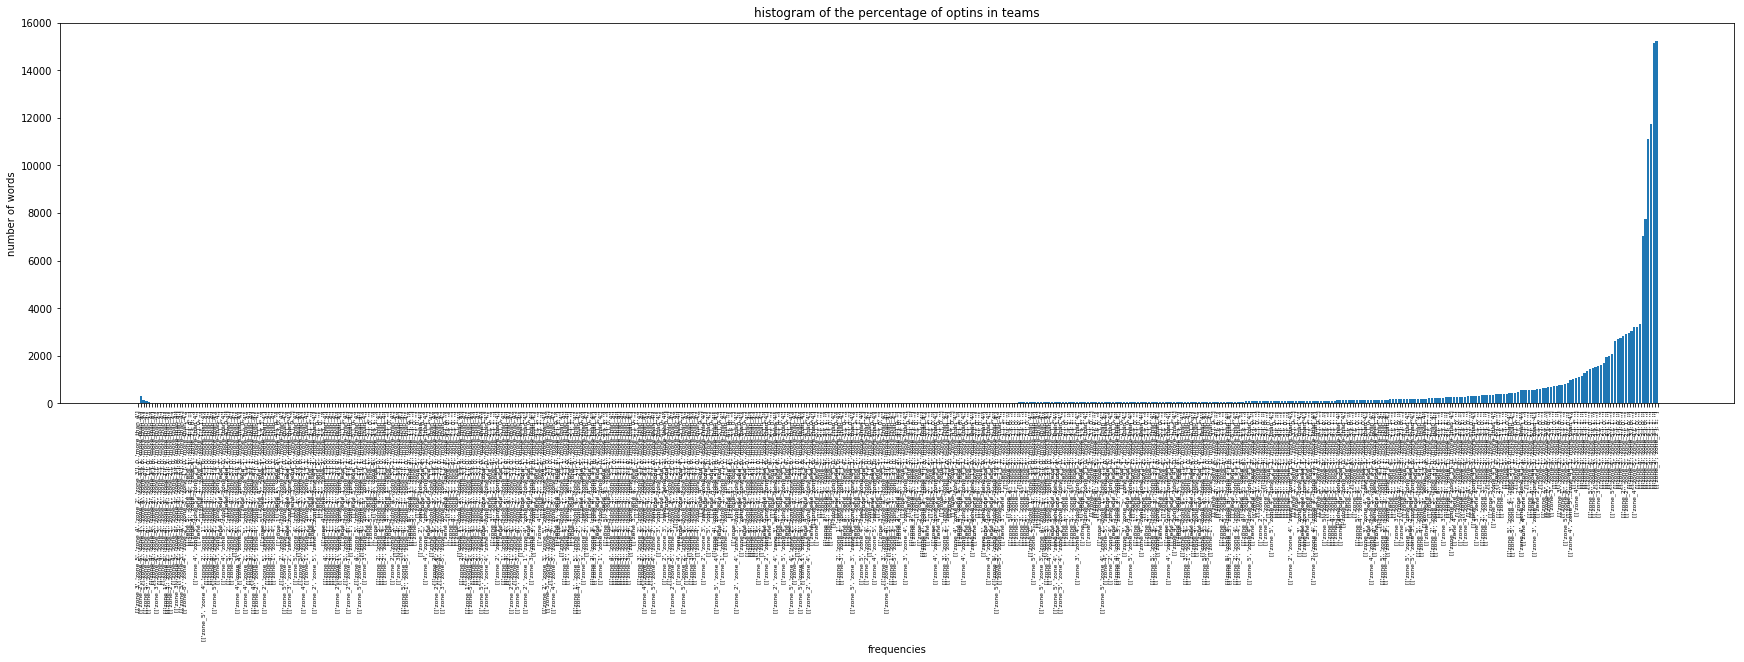

In [11]:
### frequence analysis
#create a list of all words
li_words = []
for h_day, li_li_tupleWordTime in documents.items():
    li_words.extend([x for x in li_li_tupleWordTime])
print(len(li_words), len(set(li_words)))

#compute frequencies
c_words = Counter(li_words)
df_word_frequence = pd.DataFrame.from_dict({'word':list(c_words.keys()),'frequence':list(c_words.values())})
df_word_frequence = df_word_frequence.sort_values('frequence',ascending=False)
df_word_frequence.to_csv(os.path.join(path_save,'word_Frequence.csv'),index=False,sep=';')
display(df_word_frequence.head(3))
display(df_word_frequence.tail(3))

#simple barplot (sorted with x values)
d = {k:v for k,v in c_words.items() if v>5}
d = sorted(d.items(), key=operator.itemgetter(1))
x = [i[0] for i in d]
y = [i[1] for i in d]
fig = plt.figure(figsize=(30,7))
ax = plt.subplot(111)
width = 0.8
ax.bar(range(len(x)), y, width=width)
plt.title('most frequent words')
ax.set_xticks(np.arange(len(x)) + width/2)
ax.set_xticklabels(x, rotation=90,size=6);
plt.savefig(os.path.join(path_save,'most_frequent_word_'+str(length_words)+'.png'),dpi=300,format='png',bbox_inches='tight')

#histogram
plt.hist(df_word_frequence[df_word_frequence['frequence']<=100]['frequence'],bins=100) #into 15 equal parts 
#return: [0]: vector of length bins with #elements in each bins
#and [1]: when the vectors starts (for plot)
plt.title('histogram of the percentage of optins in teams')
plt.xlabel('frequencies')
plt.ylabel('number of words')    
#--> choose the nbr_times parameter: number of times a words need to appear at least this amount of time, in the overall set of 
#documents to be taken into account
nbr_times = 10

In [12]:
### clean documents
def MLPsWord4lda(documents, c_words, nbr_times):
    #remove all words appearing less or equal to nbr_times times in the overall time series
    tokens_removed = set(word for word in c_words.keys() if c_words[word]<nbr_times)
    cleaned_documents = {h_day:[word for word in words if word not in tokens_removed] for h_day,words in documents.items()}
    #perhaps later: remove with to much transition words? keep it for now, I dont know what this means
    return(cleaned_documents, tokens_removed)

cleaned_documents, tokens_removed = MLPsWord4lda(documents, c_words, nbr_times)
len(tokens_removed)

### dictionary & bag of word corpus
#dictionary:  mapping from word IDs to words
#keep track of the order of the li_documents regarding the ts ID
dico_tsID_listID = dict(zip(list(cleaned_documents.keys()),range(len(cleaned_documents.keys()))))
dico_listID_tsID = {v:k for k,v in dico_tsID_listID.items()}
li_documents = [cleaned_documents[dico_listID_tsID[listID]] for listID in range(len(dico_listID_tsID))]
print('We have %d documents (i.e. daily hens time series). The first one has %d words (once cleaned)'%(len(li_documents), 
                                                                                                       len(li_documents[0])))
dictionary = corpora.Dictionary(li_documents)
print('There is %d words in your dictionary'%len(dictionary))

#corpus: list with a bag of words (sparse document vectors: list of tuples(word_id, appearance)) for each documents
corpus = [dictionary.doc2bow(text) for text in li_documents]
print(len(corpus),corpus[10])

#save
pickle.dump(corpus, open(os.path.join(path_save,'corpus.pkl'), 'wb'))
dictionary.save(os.path.join(path_save,'dictionary.gensim'))

We have 6919 documents (i.e. daily hens time series). The first one has 38 words (once cleaned)
There is 445 words in your dictionary
6919 [(3, 2), (4, 5), (9, 1), (10, 2), (11, 5), (12, 1), (20, 2), (22, 1), (23, 2), (28, 1), (34, 1), (36, 1), (37, 3), (39, 4), (40, 2), (53, 2), (56, 1), (59, 1), (79, 1), (80, 1), (81, 1)]


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

Total running time: 0min

---- 0
0.230*"[['zone_5', 'zone_4'], 1, '']" + 0.228*"[['zone_4', 'zone_5'], 1, '']" + 0.072*"[['zone_4', 'zone_5'], 0, '']" + 0.064*"[['zone_5', 'zone_4'], 0, '']" + 0.061*"[['zone_4', 'zone_5', 'zone_4'], 1, '']" + 0.043*"[['zone_5', 'zone_4', 'zone_5'], 1, '']" + 0.030*"[['zone_5', 'zone_4', 'zone_5'], 0, '']" + 0.019*"[['zone_4', 'zone_5', 'zone_4'], 1, 'more_than_4']" + 0.017*"[['zone_5', 'zone_4', 'zone_5', 'zone_4'], 1, '']" + 0.015*"[['zone_4', 'zone_5', 'zone_4'], 0, '']"

---- 1
0.145*"[['zone_3', 'zone_2'], 1, '']" + 0.138*"[['zone_2', 'zone_3'], 1, '']" + 0.057*"[['zone_2', 'zone_3'], 0, '']" + 0.048*"[['zone_3', 'zone_2'], 0, '']" + 0.036*"[['zone_1', 'zone_2'], 0, '']" + 0.025*"[['zone_3', 'zone_1'], 0, '']" + 0.025*"[['zone_1', 'zone_3'], 0, '']" + 0.025*"[['zone_2', 'zone_3', 'zone_2'], 1, '']" + 0.025*"[['zone_2', 'zone_1'], 0, '']" + 0.025*"[['zone_4', 'zone_3'], 1, '']"
(6919, 12)
1    4247
0    2672
Name: topic, dtype: int64


topic,0,1
HenID,,
hen_1,46.0,18.0
hen_10,2.0,10.0
hen_100,1.0,43.0


topic,0,1
HenID,,
hen_99,0.0,100.0
hen_88,0.0,100.0
hen_120,0.0,100.0


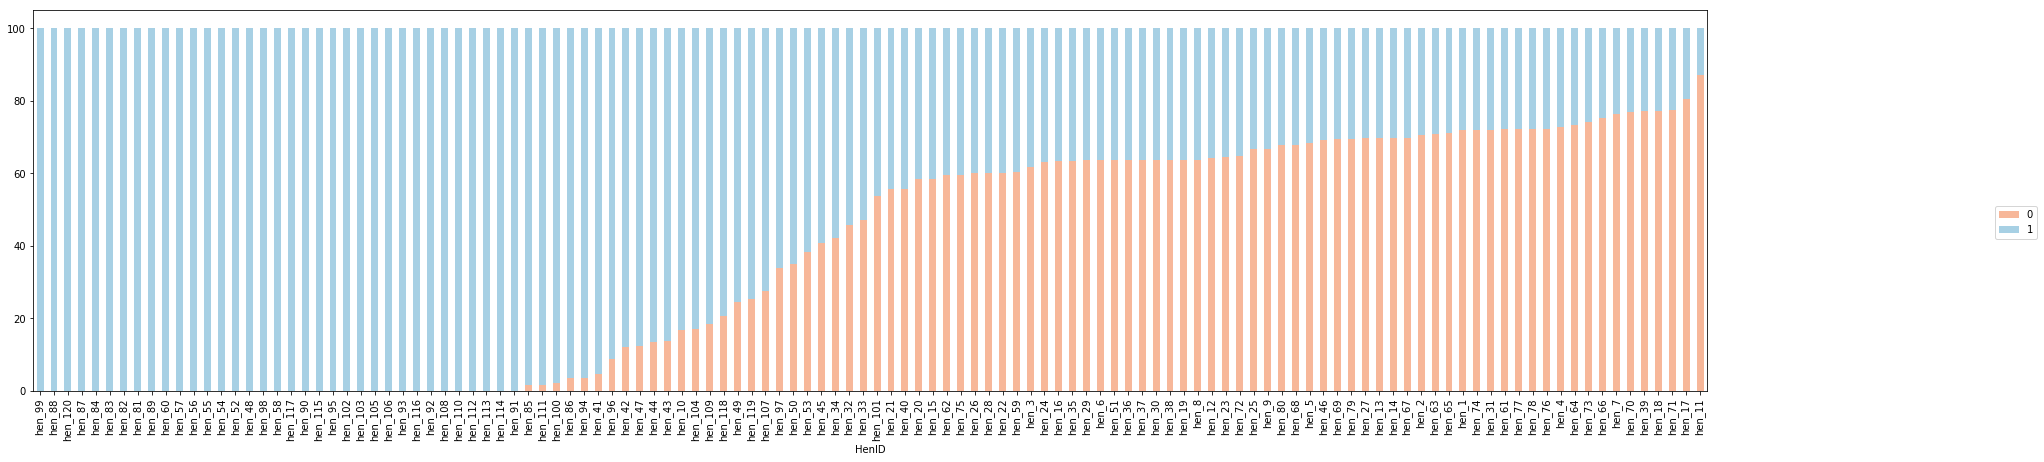

121
132


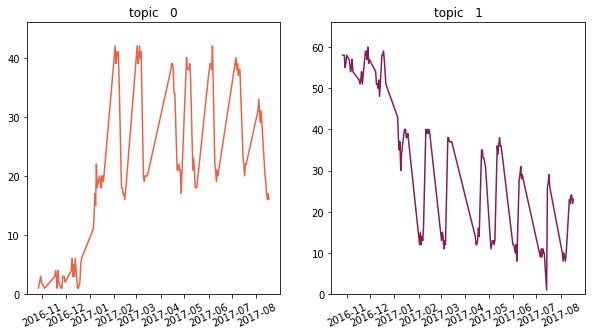

,day,documentID
0,2016-10-27,58
1,2016-10-28,58
2,2016-10-29,58


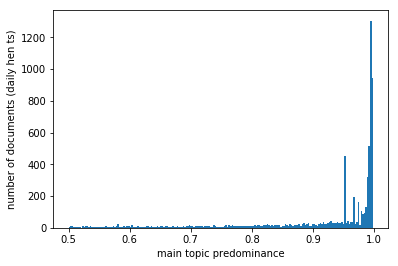


 16%|████████████▍                                                                 | 1105/6919 [00:19<02:54, 33.35it/s]


 28%|█████████████████████▌                                                        | 1908/6919 [00:37<02:00, 41.56it/s]


 61%|███████████████████████████████████████████████▏                             | 4245/6919 [00:56<00:11, 238.52it/s]


 89%|█████████████████████████████████████████████████████████████████████▋        | 6180/6919 [01:17<00:20, 35.58it/s]


  8%|██████▎                                                                           | 1/13 [02:13<26:38, 133.19s/it]

Total running time: 0min

---- 0
0.230*"[['zone_5', 'zone_4'], 1, '']" + 0.223*"[['zone_4', 'zone_5'], 1, '']" + 0.078*"[['zone_4', 'zone_5'], 0, '']" + 0.069*"[['zone_5', 'zone_4'], 0, '']" + 0.064*"[['zone_4', 'zone_5', 'zone_4'], 1, '']" + 0.043*"[['zone_5', 'zone_4', 'zone_5'], 1, '']" + 0.032*"[['zone_5', 'zone_4', 'zone_5'], 0, '']" + 0.020*"[['zone_4', 'zone_5', 'zone_4'], 1, 'more_than_4']" + 0.017*"[['zone_5', 'zone_4', 'zone_5', 'zone_4'], 1, '']" + 0.016*"[['zone_4', 'zone_5', 'zone_4'], 0, '']"

---- 1
0.055*"[['zone_2', 'zone_5'], 1, '']" + 0.053*"[['zone_4', 'zone_5'], 1, '']" + 0.043*"[['zone_5', 'zone_2'], 1, '']" + 0.043*"[['zone_1', 'zone_2'], 0, '']" + 0.042*"[['zone_3', 'zone_2'], 1, '']" + 0.041*"[['zone_2', 'zone_3'], 1, '']" + 0.031*"[['zone_2', 'zone_3'], 0, '']" + 0.030*"[['zone_5', 'zone_4'], 1, '']" + 0.030*"[['zone_2', 'zone_5'], 0, '']" + 0.025*"[['zone_3', 'zone_5'], 1, '']"

---- 2
0.190*"[['zone_3', 'zone_2'], 1, '']" + 0.181*"[['zone_2', 'zone_3'], 1, '

topic,0,1,2
HenID,,,
hen_1,44.0,8.0,12.0
hen_10,0.0,6.0,6.0
hen_100,0.0,5.0,39.0


topic,0,1,2
HenID,,,
hen_99,0.0,0.000000,100.000000
hen_88,0.0,86.666667,13.333333
hen_87,0.0,15.384615,84.615385


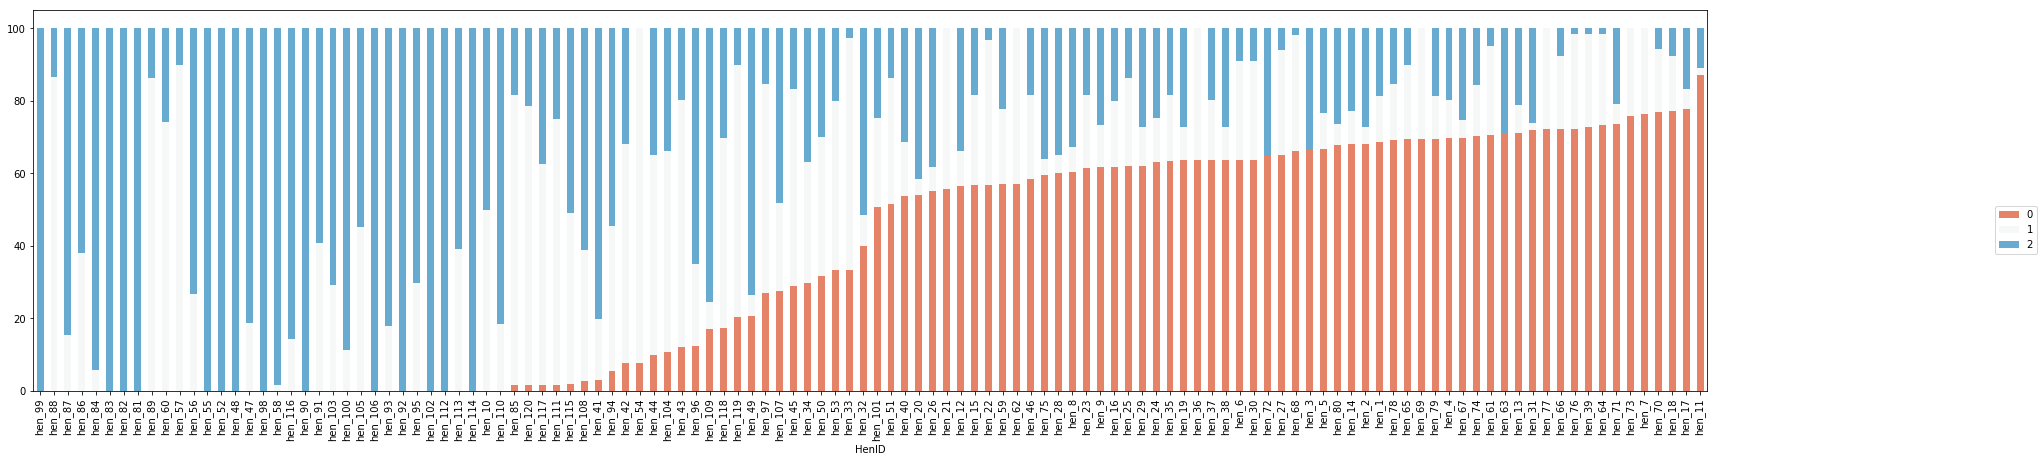

119
132
131


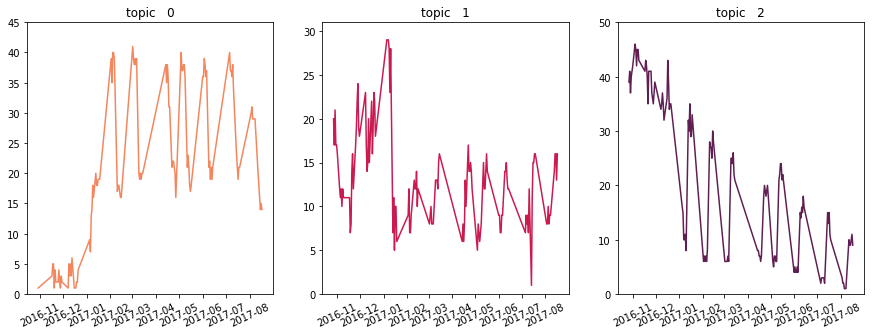

,day,documentID
0,2016-10-27,39
1,2016-10-28,41
2,2016-10-29,37


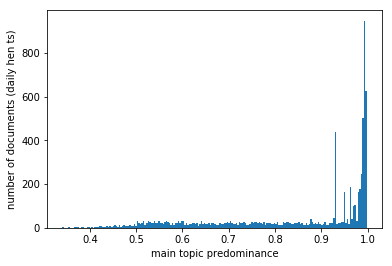


 80%|█████████████████████████████████████████████████████████████▌               | 5533/6919 [00:16<00:03, 387.41it/s]


 15%|████████████▌                                                                     | 2/13 [03:34<21:34, 117.67s/it]

Total running time: 0min

---- 0
0.233*"[['zone_4', 'zone_5'], 1, '']" + 0.231*"[['zone_5', 'zone_4'], 1, '']" + 0.074*"[['zone_4', 'zone_5'], 0, '']" + 0.066*"[['zone_5', 'zone_4'], 0, '']" + 0.062*"[['zone_4', 'zone_5', 'zone_4'], 1, '']" + 0.044*"[['zone_5', 'zone_4', 'zone_5'], 1, '']" + 0.031*"[['zone_5', 'zone_4', 'zone_5'], 0, '']" + 0.020*"[['zone_4', 'zone_5', 'zone_4'], 1, 'more_than_4']" + 0.017*"[['zone_5', 'zone_4', 'zone_5', 'zone_4'], 1, '']" + 0.015*"[['zone_4', 'zone_5', 'zone_4'], 0, '']"

---- 1
0.133*"[['zone_2', 'zone_3'], 1, '']" + 0.128*"[['zone_3', 'zone_2'], 1, '']" + 0.097*"[['zone_2', 'zone_3'], 0, '']" + 0.091*"[['zone_3', 'zone_2'], 0, '']" + 0.047*"[['zone_2', 'zone_3', 'zone_2'], 0, '']" + 0.041*"[['zone_2', 'zone_5'], 1, '']" + 0.037*"[['zone_2', 'zone_3', 'zone_2'], 1, '']" + 0.035*"[['zone_5', 'zone_2'], 1, '']" + 0.034*"[['zone_2', 'zone_5'], 0, '']" + 0.026*"[['zone_5', 'zone_4', 'zone_2'], 1, '']"

---- 2
0.094*"[['zone_4', 'zone_3'], 1, '']" + 0.07

topic,0,1,2,3
HenID,,,,
hen_1,46.0,17.0,0.0,1.0
hen_10,0.0,9.0,0.0,3.0
hen_100,2.0,13.0,0.0,29.0


topic,0,1,2,3
HenID,,,,
hen_99,0.0,9.230769,0.0,90.769231
hen_90,0.0,11.864407,0.0,88.135593
hen_89,0.0,44.827586,0.0,55.172414


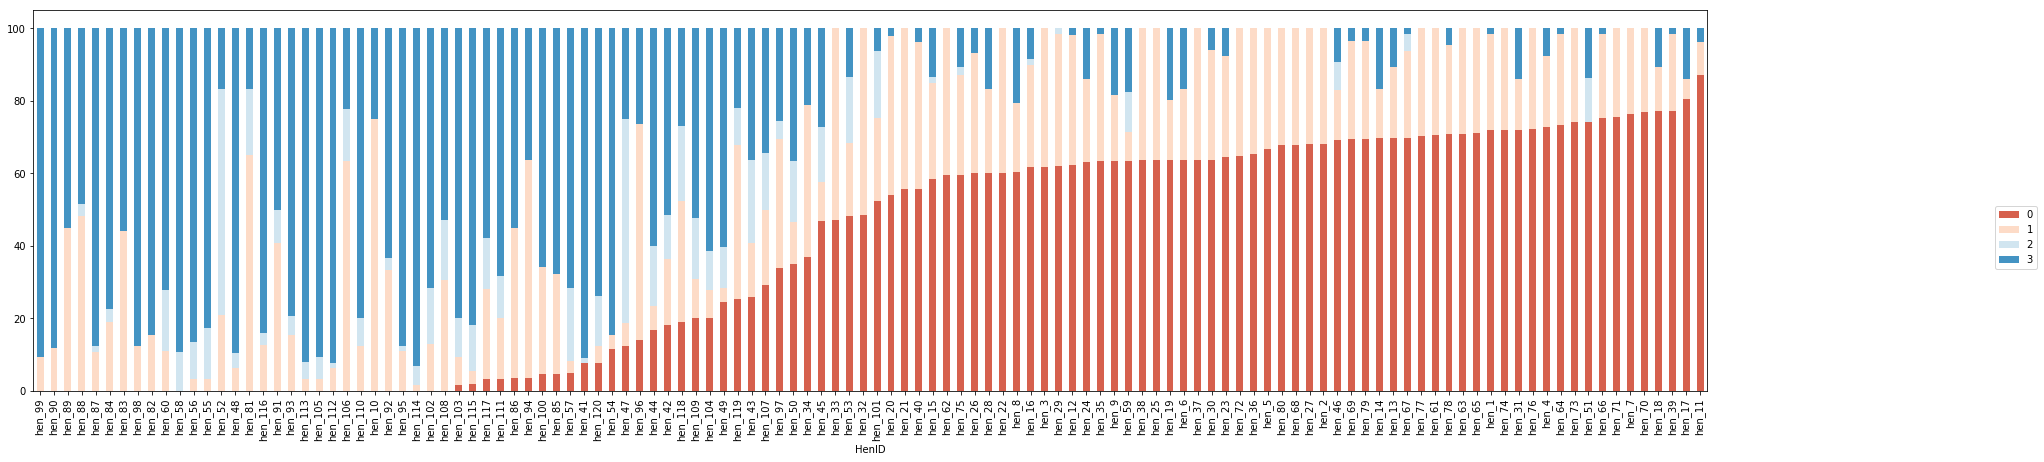

122
119
92
132


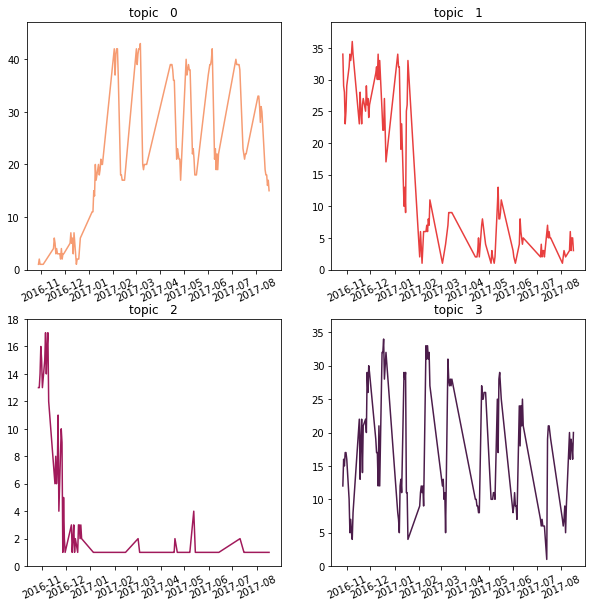

,day,documentID
0,2016-10-27,12
1,2016-10-28,16
2,2016-10-29,15


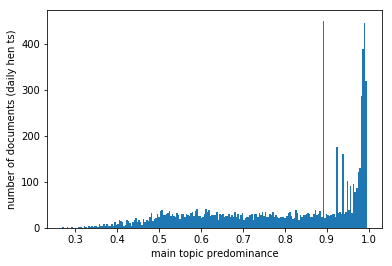


 23%|██████████████████▉                                                               | 3/13 [04:57<17:53, 107.30s/it]

Total running time: 0min

---- 0
0.115*"[['zone_2', 'zone_5'], 1, '']" + 0.089*"[['zone_5', 'zone_2'], 1, '']" + 0.080*"[['zone_4', 'zone_5'], 1, '']" + 0.058*"[['zone_2', 'zone_5'], 0, '']" + 0.043*"[['zone_2', 'zone_4'], 1, '']" + 0.042*"[['zone_3', 'zone_5'], 1, '']" + 0.041*"[['zone_5', 'zone_4', 'zone_2'], 1, '']" + 0.038*"[['zone_5', 'zone_4'], 1, '']" + 0.038*"[['zone_1', 'zone_5'], 0, '']" + 0.030*"[['zone_5', 'zone_2'], 0, '']"

---- 1
0.224*"[['zone_2', 'zone_3'], 1, '']" + 0.218*"[['zone_3', 'zone_2'], 1, '']" + 0.132*"[['zone_2', 'zone_3'], 0, '']" + 0.128*"[['zone_3', 'zone_2'], 0, '']" + 0.059*"[['zone_2', 'zone_3', 'zone_2'], 0, '']" + 0.044*"[['zone_2', 'zone_3', 'zone_2'], 1, '']" + 0.018*"[['zone_4', 'zone_3'], 1, '']" + 0.014*"[['zone_3', 'zone_2', 'zone_3'], 0, '']" + 0.011*"[['zone_3', 'zone_4'], 1, '']" + 0.010*"[['zone_3', 'zone_2', 'zone_3'], 1, '']"

---- 2
0.111*"[['zone_4', 'zone_3'], 1, '']" + 0.092*"[['zone_3', 'zone_2', 'zone_3'], 1, '']" + 0.075*"[['zone_

topic,0,1,2,3,4
HenID,,,,,
hen_1,6.0,11.0,0.0,1.0,46.0
hen_10,6.0,6.0,0.0,0.0,0.0
hen_100,3.0,16.0,0.0,24.0,1.0


topic,0,1,2,3,4
HenID,,,,,
hen_99,0.0,20.0,0.0,80.0,0.0
hen_3,0.0,35.0,0.0,0.0,65.0
hen_31,0.0,14.0,0.0,14.0,72.0


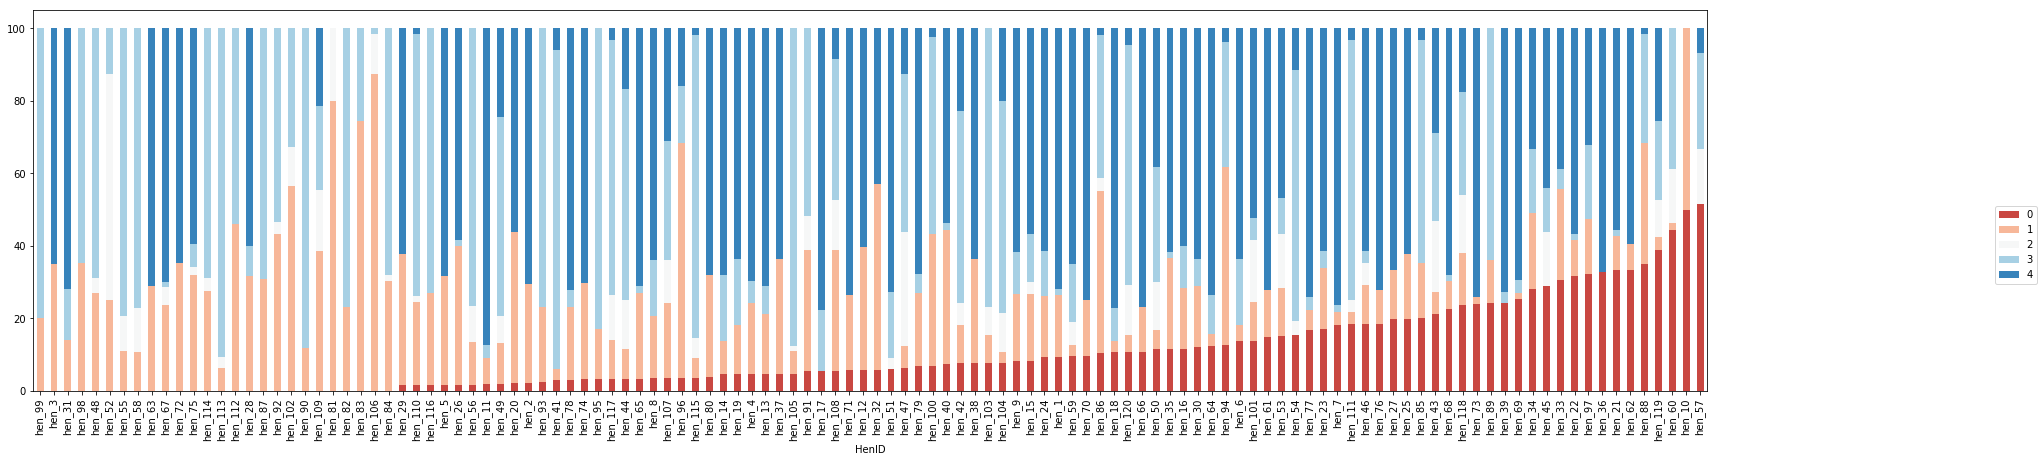

129
110
79
131
123


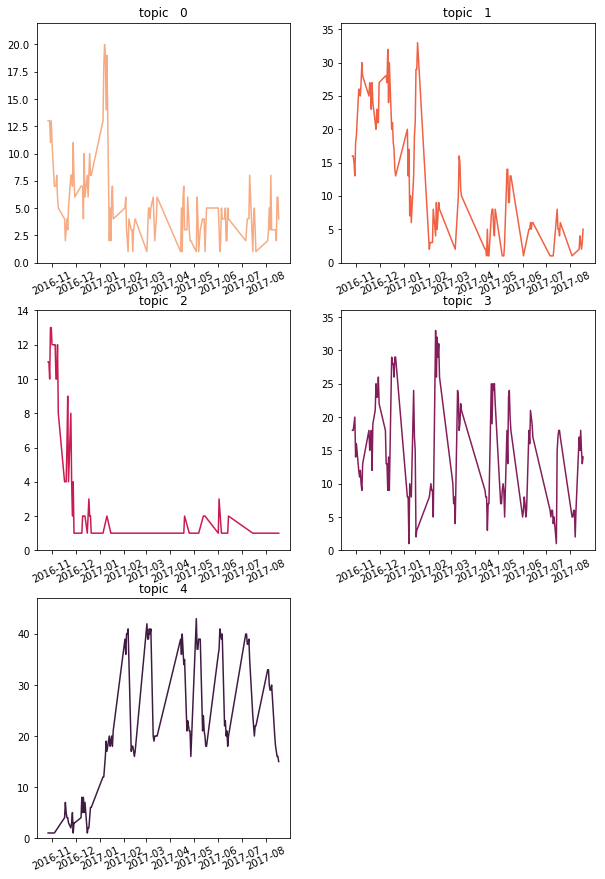

,day,documentID
0,2016-10-27,1
1,2016-10-29,1
2,2016-10-30,1


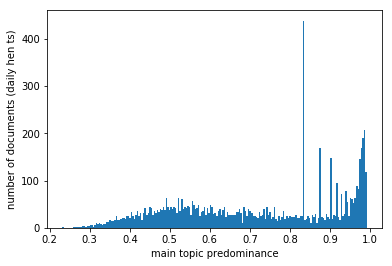


 93%|███████████████████████████████████████████████████████████████████████▊     | 6451/6919 [00:16<00:01, 241.42it/s]


 31%|█████████████████████████▏                                                        | 4/13 [06:21<15:01, 100.13s/it]

Total running time: 0min

---- 0
0.145*"[['zone_2', 'zone_5'], 1, '']" + 0.113*"[['zone_5', 'zone_2'], 1, '']" + 0.078*"[['zone_2', 'zone_5'], 0, '']" + 0.057*"[['zone_5', 'zone_4', 'zone_2'], 1, '']" + 0.053*"[['zone_2', 'zone_4'], 1, '']" + 0.053*"[['zone_4', 'zone_5'], 1, '']" + 0.045*"[['zone_3', 'zone_5'], 1, '']" + 0.038*"[['zone_5', 'zone_2'], 0, '']" + 0.034*"[['zone_4', 'zone_2'], 1, '']" + 0.031*"[['zone_1', 'zone_5'], 0, '']"

---- 1
0.248*"[['zone_2', 'zone_3'], 1, '']" + 0.247*"[['zone_3', 'zone_2'], 1, '']" + 0.126*"[['zone_2', 'zone_3'], 0, '']" + 0.119*"[['zone_3', 'zone_2'], 0, '']" + 0.050*"[['zone_2', 'zone_3', 'zone_2'], 1, '']" + 0.044*"[['zone_2', 'zone_3', 'zone_2'], 0, '']" + 0.016*"[['zone_4', 'zone_3'], 1, '']" + 0.011*"[['zone_3', 'zone_2', 'zone_3'], 0, '']" + 0.009*"[['zone_3', 'zone_2', 'zone_3'], 1, '']" + 0.009*"[['zone_3', 'zone_4'], 1, '']"

---- 2
0.131*"[['zone_5', 'zone_4', 'zone_5'], 0, 'more_than_4']" + 0.125*"[['zone_5', 'zone_4'], 1, 'more_than_

topic,0,1,2,3,4,5
HenID,,,,,,
hen_1,6.0,12.0,0.0,0.0,46.0,0.0
hen_10,6.0,6.0,0.0,0.0,0.0,0.0
hen_100,1.0,23.0,0.0,18.0,2.0,0.0


topic,0,1,2,3,4,5
HenID,,,,,,
hen_99,0.0,30.769231,0.0,69.230769,0.000000,0.0
hen_98,0.0,50.769231,0.0,49.230769,0.000000,0.0
hen_72,0.0,35.294118,0.0,0.000000,64.705882,0.0


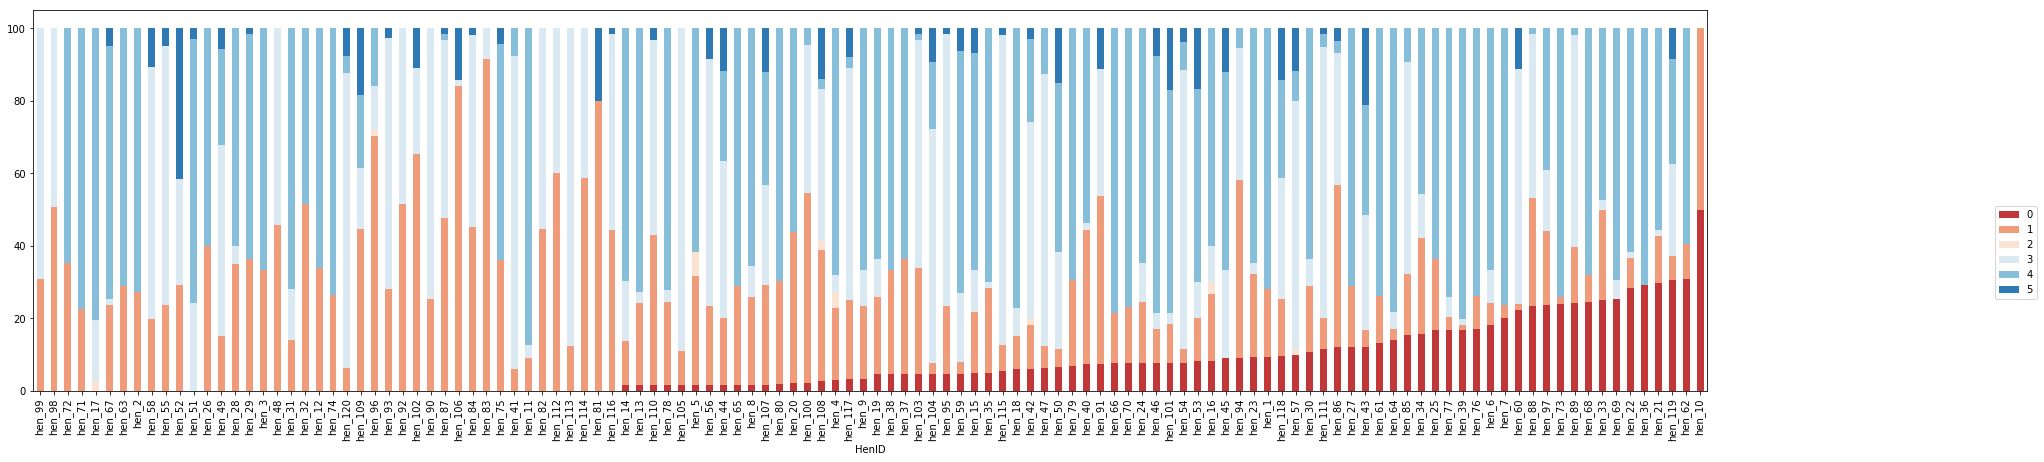

114
117
10
131
125
85


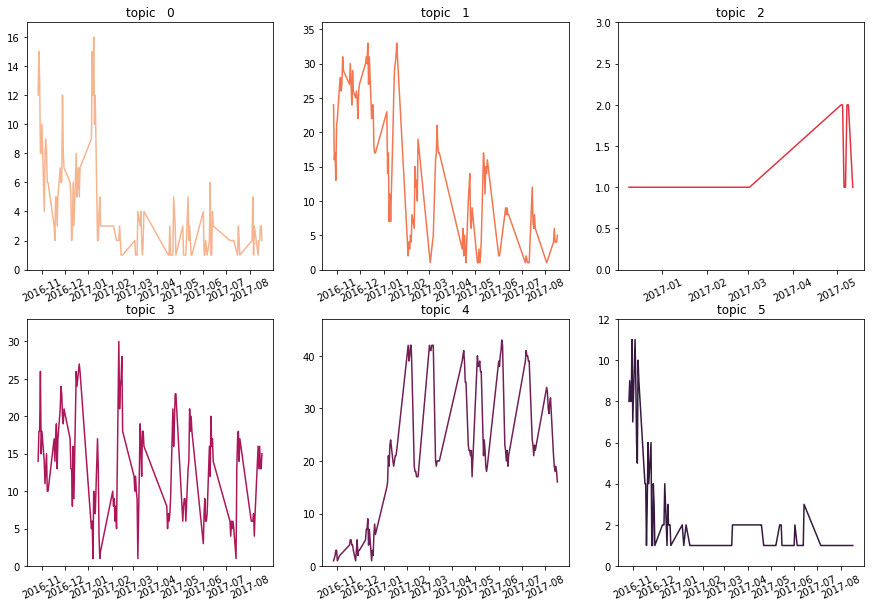

,day,documentID
0,2016-10-27,8
1,2016-10-28,9
2,2016-10-29,8


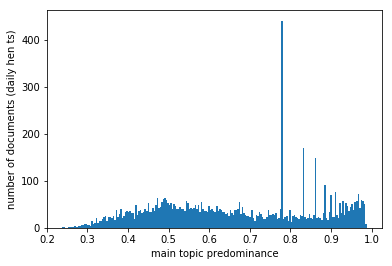


 96%|█████████████████████████████████████████████████████████████████████████▋   | 6617/6919 [00:17<00:00, 427.60it/s]


 38%|███████████████████████████████▉                                                   | 5/13 [07:44<12:41, 95.17s/it]

Total running time: 0min

---- 0
0.097*"[['zone_4', 'zone_3'], 1, '']" + 0.089*"[['zone_3', 'zone_4'], 1, '']" + 0.089*"[['zone_5', 'zone_4'], 1, 'more_than_4']" + 0.068*"[['zone_3', 'zone_4', 'zone_3'], 1, '']" + 0.064*"[['zone_5', 'zone_3'], 1, '']" + 0.046*"[['zone_3', 'zone_4', 'zone_3'], 1, 'more_than_4']" + 0.045*"[['zone_3', 'zone_2', 'zone_3'], 1, '']" + 0.039*"[['zone_4', 'zone_3', 'zone_4'], 0, '']" + 0.034*"[['zone_3', 'zone_5'], 1, '']" + 0.033*"[['zone_3', 'zone_4', 'zone_3'], 0, '']"

---- 1
0.257*"[['zone_5', 'zone_4'], 1, '']" + 0.251*"[['zone_4', 'zone_5'], 1, '']" + 0.082*"[['zone_4', 'zone_5'], 0, '']" + 0.073*"[['zone_5', 'zone_4'], 0, '']" + 0.070*"[['zone_4', 'zone_5', 'zone_4'], 1, '']" + 0.045*"[['zone_5', 'zone_4', 'zone_5'], 1, '']" + 0.034*"[['zone_5', 'zone_4', 'zone_5'], 0, '']" + 0.022*"[['zone_4', 'zone_5', 'zone_4'], 1, 'more_than_4']" + 0.020*"[['zone_5', 'zone_4', 'zone_5', 'zone_4'], 1, '']" + 0.017*"[['zone_4', 'zone_5', 'zone_4'], 0, '']"

---- 2
0.

topic,0,1,2,3,4,5,6
HenID,,,,,,,
hen_1,0.0,46.0,0.0,1.0,5.0,12.0,0.0
hen_10,0.0,0.0,0.0,0.0,5.0,6.0,1.0
hen_100,0.0,1.0,0.0,22.0,0.0,18.0,3.0


topic,0,1,2,3,4,5,6
HenID,,,,,,,
hen_1,0.0,71.875000,0.0,1.5625,7.812500,18.750000,0.000000
hen_69,0.0,69.491525,0.0,0.0000,22.033898,3.389831,5.084746
hen_68,0.0,67.924528,0.0,0.0000,13.207547,11.320755,7.547170


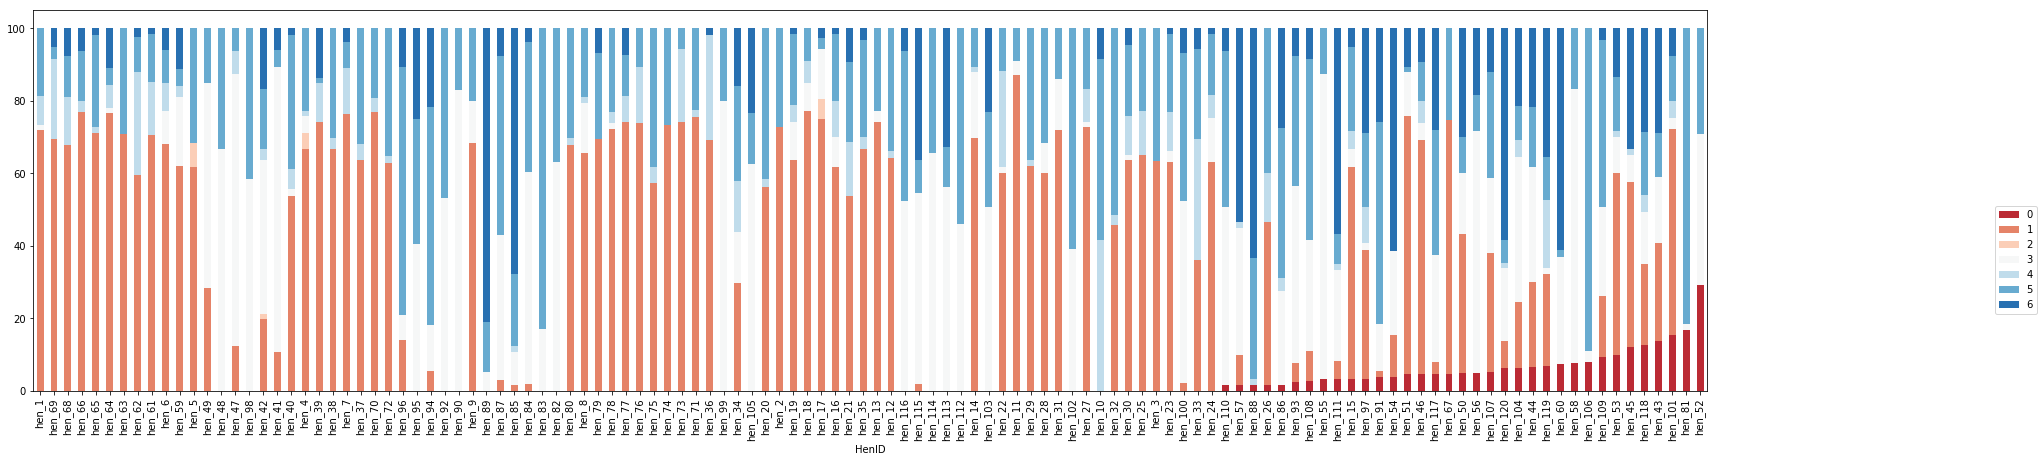

72
125
7
129
86
116
128


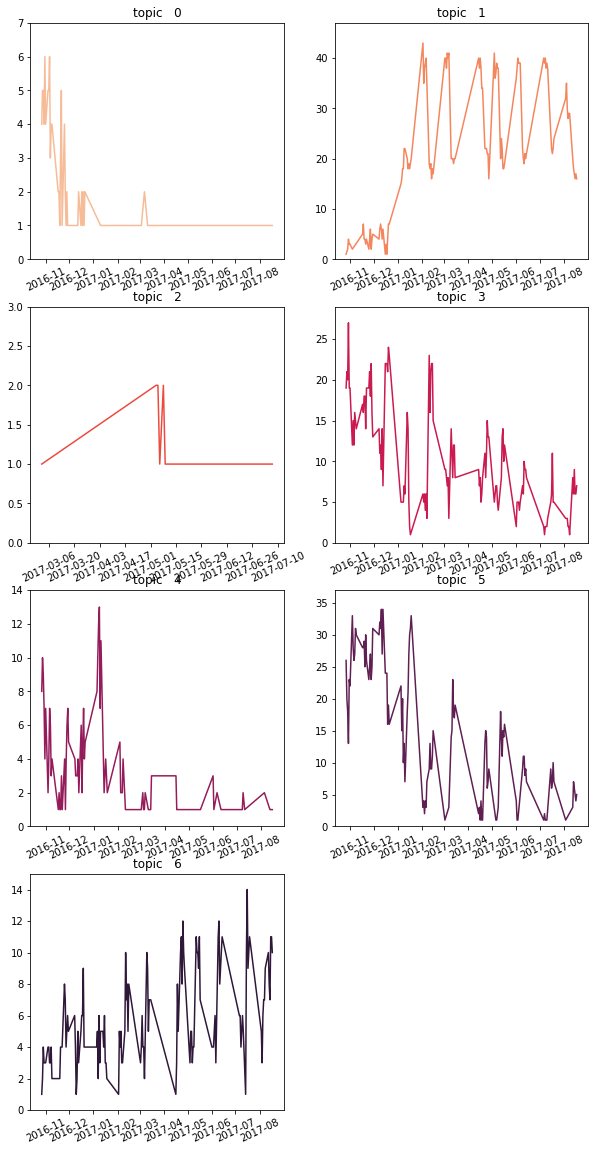

,day,documentID
0,2016-10-27,1
1,2016-10-28,2
2,2016-10-29,4


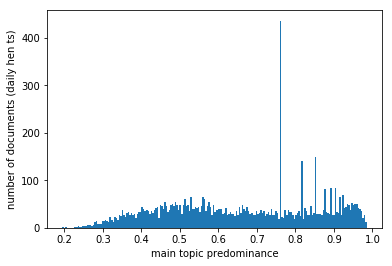


 46%|██████████████████████████████████████▎                                            | 6/13 [09:09<10:44, 92.05s/it]

Total running time: 0min

---- 0
0.273*"[['zone_4', 'zone_5', 'zone_4'], 1, 'more_than_4']" + 0.202*"[['zone_4', 'zone_5', 'zone_4'], 0, '']" + 0.116*"[['zone_5', 'zone_4'], 1, 'more_than_4']" + 0.114*"[['zone_4', 'zone_5', 'zone_4'], 1, '']" + 0.083*"[['zone_5', 'zone_4', 'zone_5', 'zone_4'], 0, '']" + 0.050*"[['zone_4', 'zone_3', 'zone_4'], 0, '']" + 0.023*"[['zone_4', 'zone_3'], 0, '']" + 0.016*"[['zone_4', 'zone_3', 'zone_4'], 0, 'more_than_4']" + 0.014*"[['zone_5', 'zone_3'], 0, '']" + 0.013*"[['zone_4', 'zone_3', 'zone_5', 'zone_4'], 0, '']"

---- 1
0.267*"[['zone_5', 'zone_4'], 1, '']" + 0.263*"[['zone_4', 'zone_5'], 1, '']" + 0.085*"[['zone_4', 'zone_5'], 0, '']" + 0.076*"[['zone_5', 'zone_4'], 0, '']" + 0.063*"[['zone_4', 'zone_5', 'zone_4'], 1, '']" + 0.047*"[['zone_5', 'zone_4', 'zone_5'], 1, '']" + 0.035*"[['zone_5', 'zone_4', 'zone_5'], 0, '']" + 0.020*"[['zone_5', 'zone_4', 'zone_5', 'zone_4'], 1, '']" + 0.015*"[['zone_4', 'zone_3', 'zone_4'], 1, '']" + 0.013*"[['zone_4',

topic,0,1,2,3,4,5,6,7
HenID,,,,,,,,
hen_1,1.0,45.0,0.0,1.0,5.0,8.0,4.0,0.0
hen_10,0.0,0.0,0.0,1.0,6.0,5.0,0.0,0.0
hen_100,0.0,1.0,0.0,22.0,1.0,17.0,1.0,2.0


topic,0,1,2,3,4,5,6,7
HenID,,,,,,,,
hen_44,0.0,26.666667,3.333333,26.666667,0.000000,18.333333,0.000000,25.000000
hen_7,0.0,76.363636,0.000000,1.818182,20.000000,1.818182,0.000000,0.000000
hen_69,0.0,69.491525,0.000000,3.389831,18.644068,0.000000,5.084746,3.389831


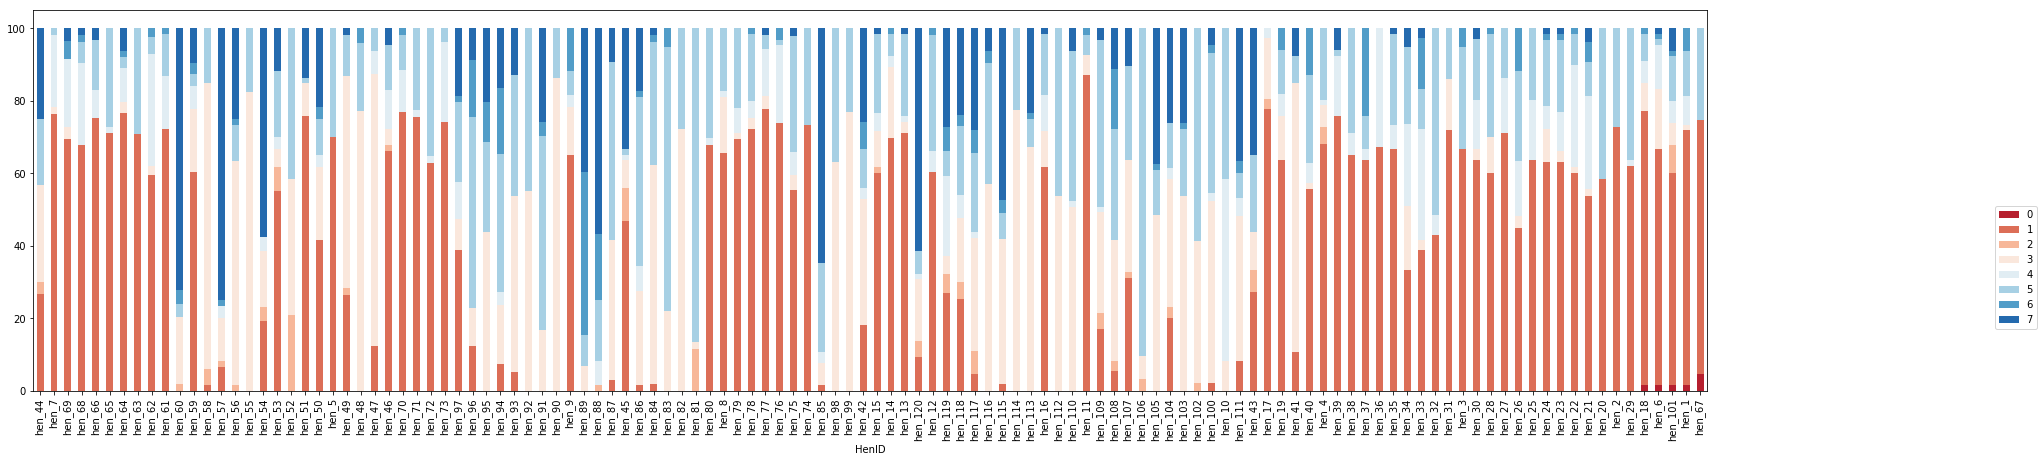

6
124
44
129
100
116
87
126


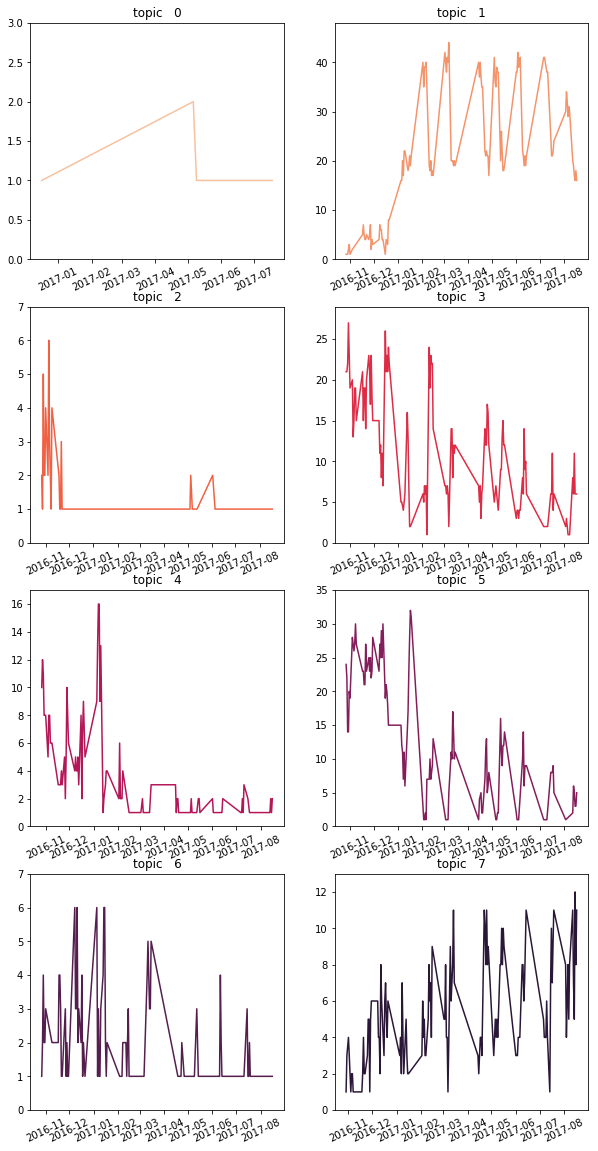

,day,documentID
0,2016-10-29,1
1,2016-10-30,3
2,2016-11-01,4


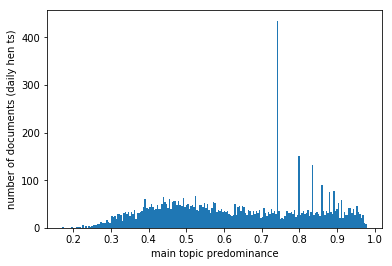


 98%|███████████████████████████████████████████████████████████████████████████▎ | 6770/6919 [00:17<00:00, 325.55it/s]


 54%|████████████████████████████████████████████▋                                      | 7/13 [10:39<09:08, 91.37s/it]

Total running time: 0min

---- 0
0.135*"[['zone_4', 'zone_3'], 1, '']" + 0.129*"[['zone_3', 'zone_4', 'zone_3'], 1, '']" + 0.124*"[['zone_3', 'zone_4'], 1, '']" + 0.081*"[['zone_3', 'zone_4', 'zone_3'], 1, 'more_than_4']" + 0.074*"[['zone_3', 'zone_2', 'zone_3'], 1, '']" + 0.056*"[['zone_4', 'zone_3', 'zone_4'], 0, '']" + 0.048*"[['zone_3', 'zone_4', 'zone_3'], 0, '']" + 0.036*"[['zone_3', 'zone_4', 'zone_3'], 0, 'more_than_4']" + 0.034*"[['zone_3', 'zone_5'], 1, '']" + 0.034*"[['zone_4', 'zone_3'], 0, '']"

---- 1
0.399*"[['zone_3', 'zone_2'], 1, '']" + 0.378*"[['zone_2', 'zone_3'], 1, '']" + 0.057*"[['zone_2', 'zone_3', 'zone_2'], 1, '']" + 0.031*"[['zone_4', 'zone_3'], 1, '']" + 0.031*"[['zone_2', 'zone_3', 'zone_2'], 0, '']" + 0.021*"[['zone_2', 'zone_3'], 0, '']" + 0.015*"[['zone_3', 'zone_2', 'zone_3'], 1, '']" + 0.007*"[['zone_2', 'zone_1', 'zone_2'], 1, '']" + 0.007*"[['zone_1', 'zone_3', 'zone_2'], 0, '']" + 0.006*"[['zone_2', 'zone_1', 'zone_3'], 1, '']"

---- 2
0.355*"[['zon

topic,0,1,2,3,4,5,6,7,8
HenID,,,,,,,,,
hen_1,0.0,11.0,0.0,0.0,46.0,0.0,7.0,0.0,0.0
hen_10,0.0,6.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0
hen_100,0.0,22.0,0.0,2.0,2.0,10.0,1.0,7.0,0.0


topic,0,1,2,3,4,5,6,7,8
HenID,,,,,,,,,
hen_1,0.0,17.187500,0.0,0.000000,71.875000,0.000000,10.937500,0.0,0.0
hen_66,0.0,6.153846,0.0,1.538462,76.923077,4.615385,10.769231,0.0,0.0
hen_65,0.0,5.084746,0.0,1.694915,71.186441,15.254237,6.779661,0.0,0.0


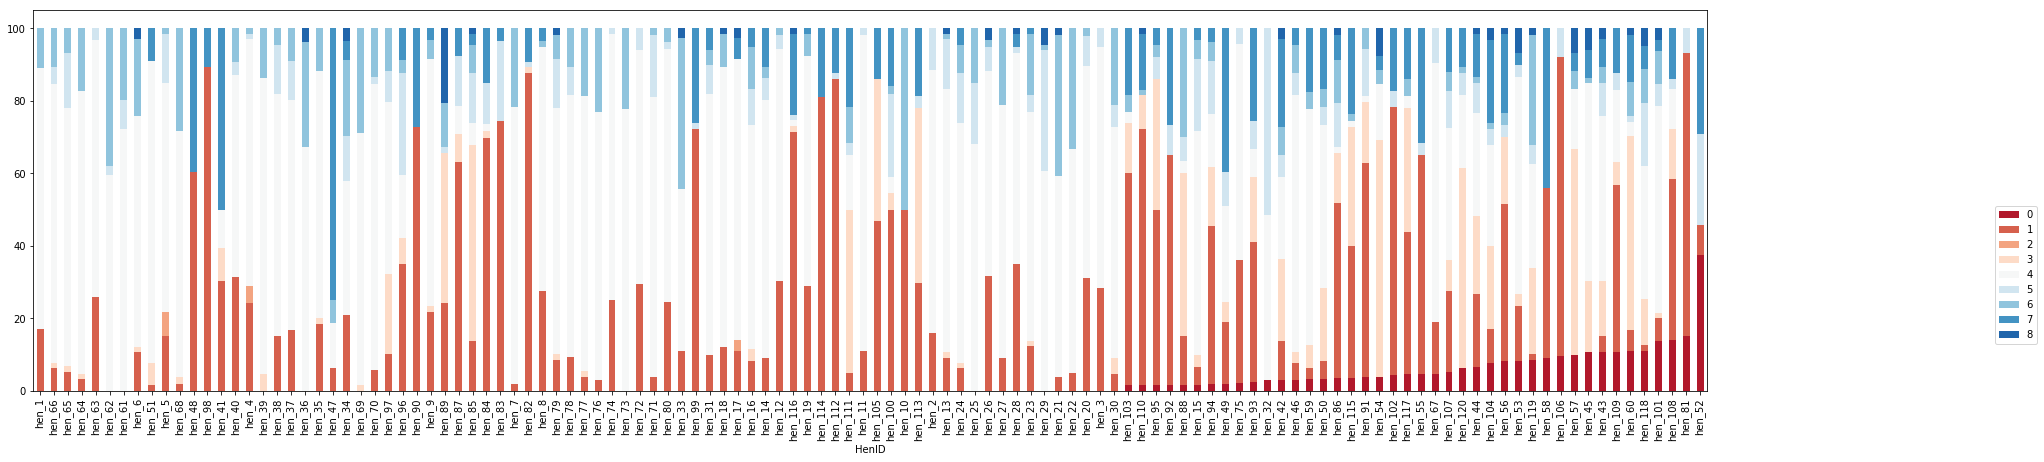

61
129
5
126
126
85
103
110
52


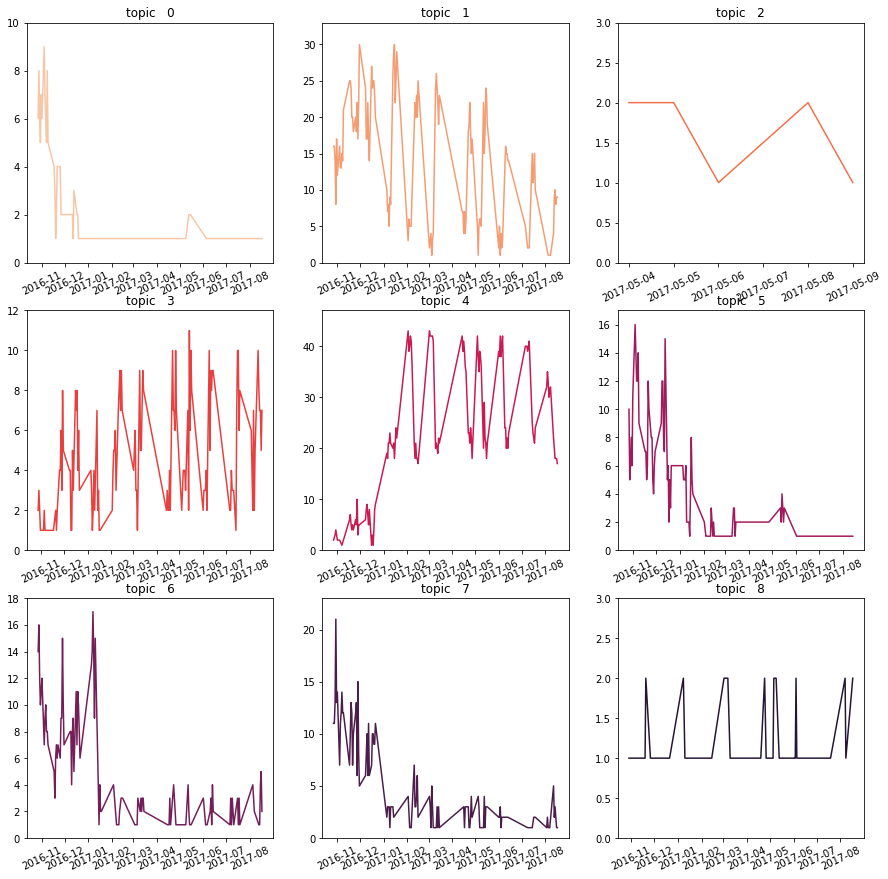

,day,documentID
0,2016-10-29,1
1,2016-11-19,1
2,2016-11-20,2


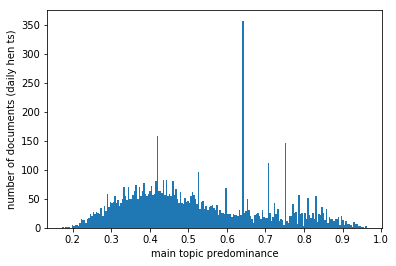


 62%|███████████████████████████████████████████████████                                | 8/13 [11:57<07:17, 87.54s/it]

Total running time: 0min

---- 0
0.470*"[['zone_4', 'zone_3', 'zone_4'], 1, '']" + 0.086*"[['zone_4', 'zone_3', 'zone_4'], 0, '']" + 0.056*"[['zone_3', 'zone_4', 'zone_3'], 0, 'more_than_4']" + 0.053*"[['zone_4', 'zone_3'], 0, '']" + 0.046*"[['zone_3', 'zone_4'], 0, '']" + 0.030*"[['zone_5', 'zone_3'], 0, '']" + 0.027*"[['zone_4', 'zone_3', 'zone_4'], 0, 'more_than_4']" + 0.027*"[['zone_5', 'zone_3', 'zone_4', 'zone_1'], 1, 'more_than_4']" + 0.024*"[['zone_3', 'zone_5'], 0, '']" + 0.020*"[['zone_5', 'zone_2', 'zone_3'], 1, '']"

---- 1
0.344*"[['zone_4', 'zone_5'], 1, '']" + 0.336*"[['zone_5', 'zone_4'], 1, '']" + 0.092*"[['zone_4', 'zone_5', 'zone_4'], 1, '']" + 0.062*"[['zone_5', 'zone_4', 'zone_5'], 1, '']" + 0.025*"[['zone_5', 'zone_4', 'zone_5', 'zone_4'], 1, '']" + 0.021*"[['zone_4', 'zone_5', 'zone_4'], 0, '']" + 0.017*"[['zone_4', 'zone_5', 'zone_4', 'zone_5'], 1, '']" + 0.013*"[['zone_5', 'zone_4', 'zone_5'], 0, 'more_than_4']" + 0.011*"[['zone_5', 'zone_3', 'zone_4'], 1, '']"

topic,0,1,2,3,4,5,6,7,8,9
HenID,,,,,,,,,,
hen_1,0.0,46.0,0.0,0.0,0.0,12.0,6.0,0.0,0.0,0.0
hen_10,0.0,0.0,0.0,0.0,0.0,6.0,6.0,0.0,0.0,0.0
hen_100,0.0,2.0,0.0,2.0,0.0,38.0,2.0,0.0,0.0,0.0


topic,0,1,2,3,4,5,6,7,8,9
HenID,,,,,,,,,,
hen_1,0.0,71.875000,0.0,0.000000,0.0,18.750000,9.375000,0.0,0.0,0.0
hen_7,0.0,76.363636,0.0,0.000000,0.0,3.636364,20.000000,0.0,0.0,0.0
hen_69,0.0,69.491525,0.0,1.694915,0.0,0.000000,28.813559,0.0,0.0,0.0


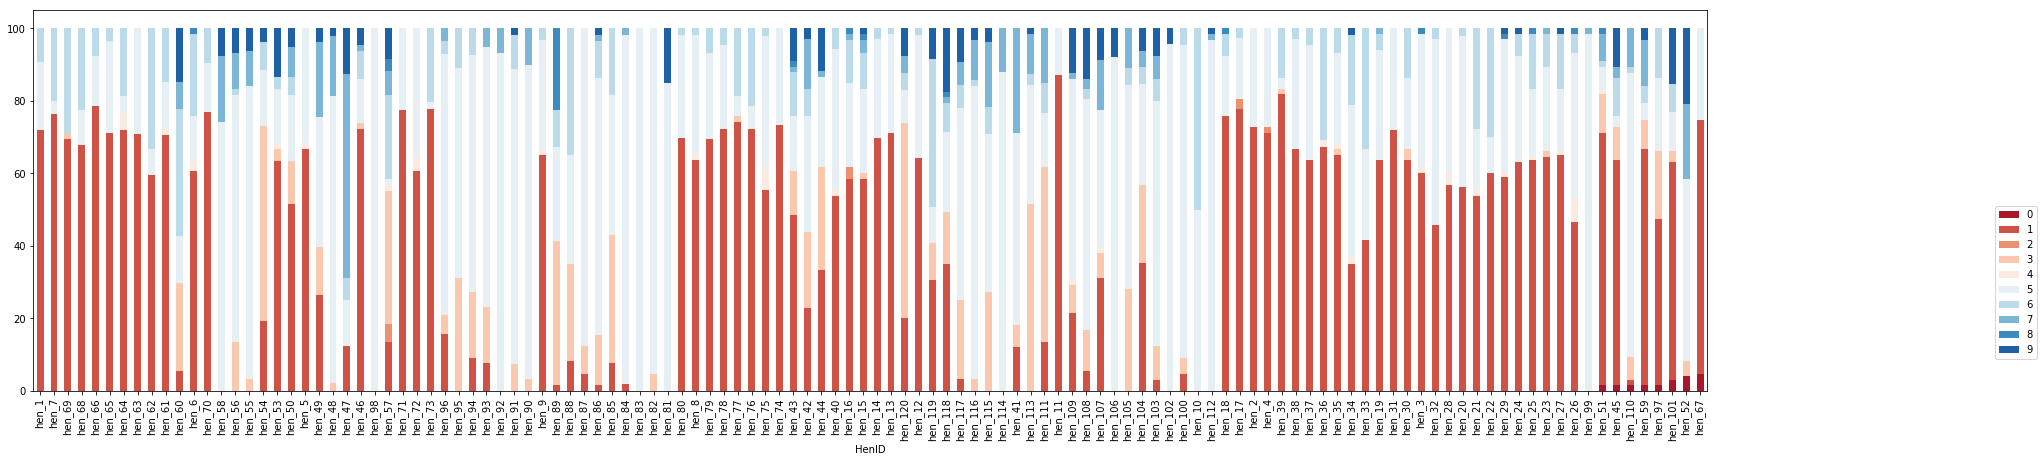

11
123
6
114
29
131
123
59
22
56


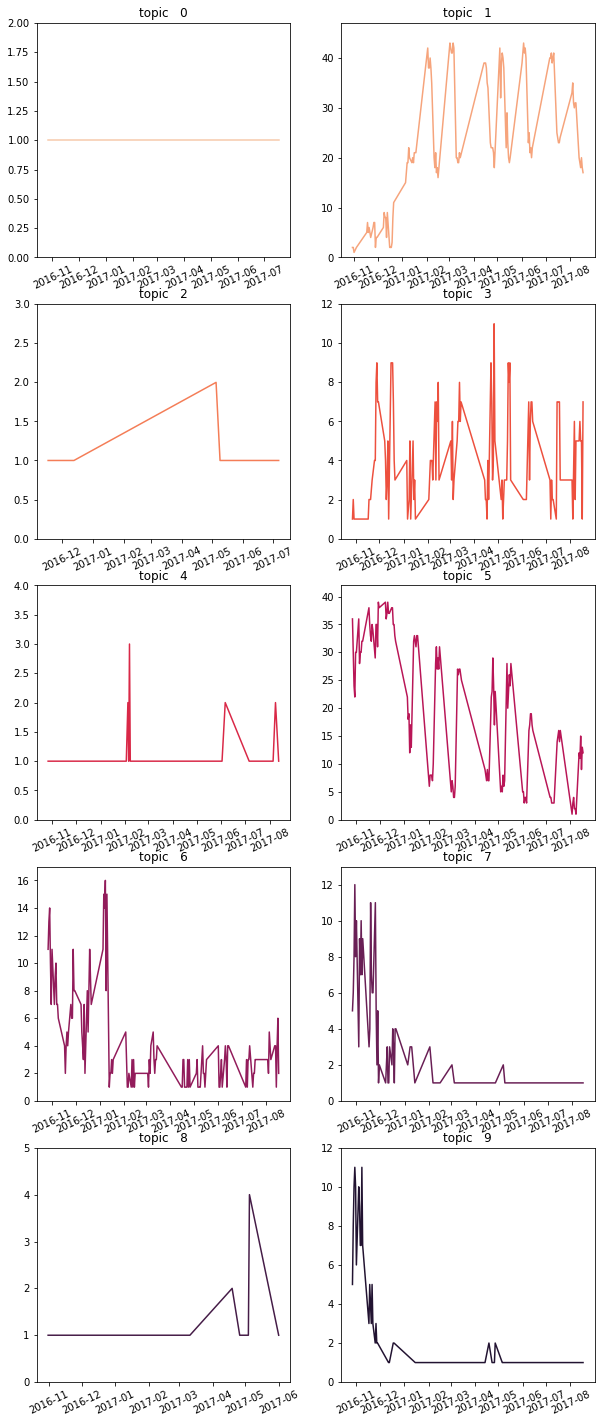

,day,documentID
0,2016-10-27,5
1,2016-10-28,8
2,2016-10-29,10


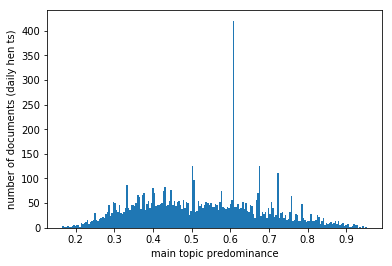


 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [13:11<05:32, 83.21s/it]

Total running time: 0min

---- 0
0.506*"[['zone_4', 'zone_5', 'zone_4'], 1, 'more_than_4']" + 0.154*"[['zone_5', 'zone_4', 'zone_5', 'zone_4'], 0, '']" + 0.070*"[['zone_4', 'zone_5', 'zone_4'], 1, '']" + 0.057*"[['zone_4', 'zone_3'], 0, '']" + 0.037*"[['zone_3', 'zone_5', 'zone_4'], 1, '']" + 0.032*"[['zone_5', 'zone_3'], 0, '']" + 0.024*"[['zone_3', 'zone_4'], 0, '']" + 0.022*"[['zone_3', 'zone_5'], 0, '']" + 0.017*"[['zone_3', 'zone_4', 'zone_2'], 0, 'more_than_4']" + 0.010*"[['zone_5', 'zone_3', 'zone_2'], 1, '']"

---- 1
0.281*"[['zone_4', 'zone_5'], 1, '']" + 0.279*"[['zone_5', 'zone_4'], 1, '']" + 0.087*"[['zone_4', 'zone_5'], 0, '']" + 0.078*"[['zone_5', 'zone_4'], 0, '']" + 0.073*"[['zone_4', 'zone_5', 'zone_4'], 1, '']" + 0.052*"[['zone_5', 'zone_4', 'zone_5'], 1, '']" + 0.021*"[['zone_5', 'zone_4', 'zone_5', 'zone_4'], 1, '']" + 0.015*"[['zone_4', 'zone_3', 'zone_4'], 1, '']" + 0.011*"[['zone_5', 'zone_4', 'zone_5'], 0, 'more_than_4']" + 0.009*"[['zone_5', 'zone_3', 'zone_4']

topic,0,1,2,3,4,5,6,7,8,9,10
HenID,,,,,,,,,,,
hen_1,0.0,46.0,0.0,1.0,0.0,11.0,6.0,0.0,0.0,0.0,0.0
hen_10,0.0,0.0,0.0,0.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0
hen_100,0.0,1.0,0.0,13.0,0.0,27.0,2.0,1.0,0.0,0.0,0.0


topic,0,1,2,3,4,5,6,7,8,9,10
HenID,,,,,,,,,,,
hen_1,0.0,71.875000,0.0,1.562500,0.0,17.187500,9.375000,0.0,0.0,0.0,0.0
hen_7,0.0,76.363636,0.0,1.818182,0.0,3.636364,18.181818,0.0,0.0,0.0,0.0
hen_69,0.0,69.491525,0.0,3.389831,0.0,0.000000,27.118644,0.0,0.0,0.0,0.0


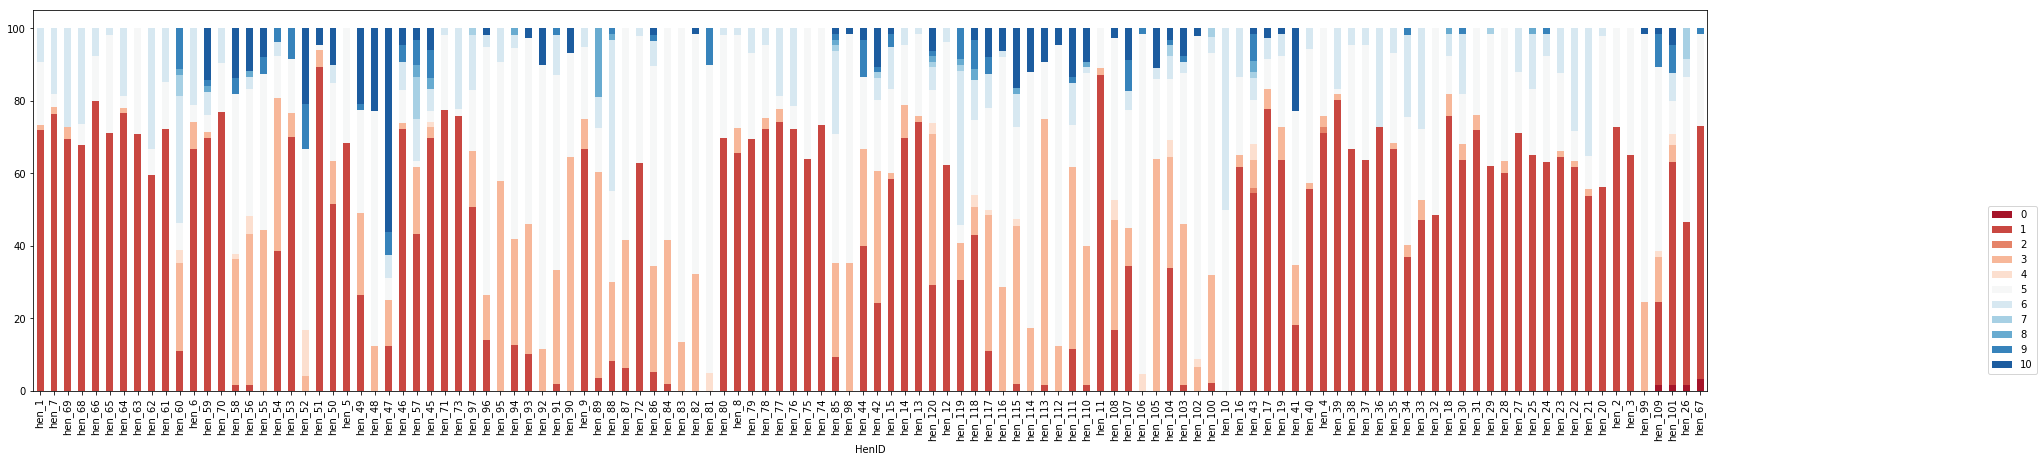

5
125
2
127
18
128
123
23
30
53
53


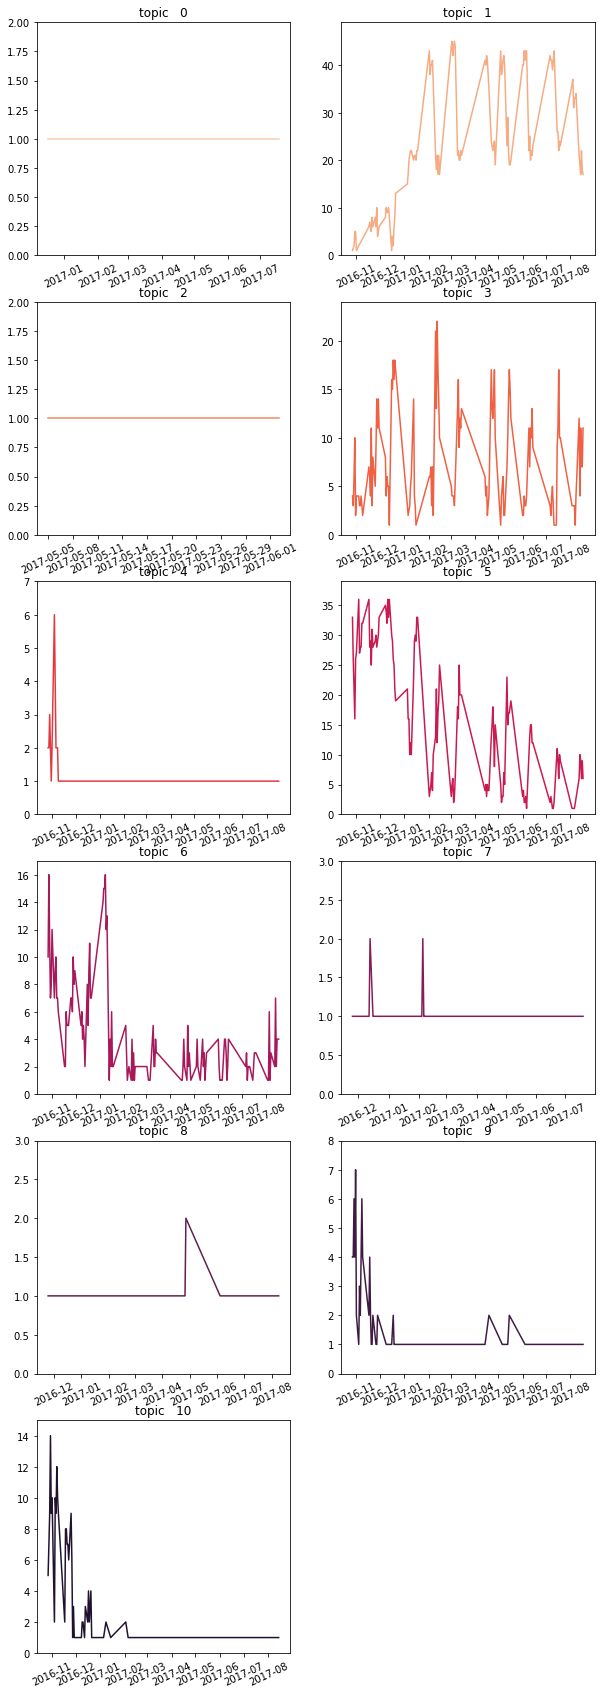

,day,documentID
0,2016-10-27,5
1,2016-10-28,7
2,2016-10-29,9


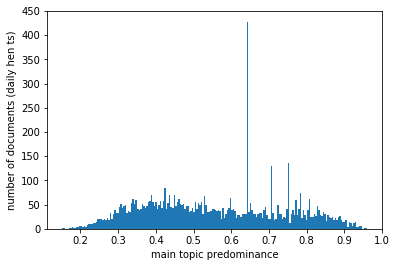


 77%|███████████████████████████████████████████████████████████████                   | 10/13 [14:29<04:05, 81.93s/it]

Total running time: 0min

---- 0
0.614*"[['zone_4', 'zone_5', 'zone_4'], 1, 'more_than_4']" + 0.100*"[['zone_5', 'zone_3', 'zone_4', 'zone_5'], 1, 'more_than_4']" + 0.075*"[['zone_5', 'zone_3'], 0, '']" + 0.065*"[['zone_5', 'zone_2', 'zone_5'], 1, '']" + 0.035*"[['zone_5', 'zone_3', 'zone_4', 'zone_1'], 1, 'more_than_4']" + 0.022*"[['zone_5', 'zone_3', 'zone_4', 'zone_2', 'zone_5'], 0, 'more_than_4']" + 0.018*"[['zone_3', 'zone_5'], 0, '']" + 0.012*"[['zone_5', 'zone_3', 'zone_2'], 1, '']" + 0.011*"[['zone_2', 'zone_3', 'zone_5'], 1, '']" + 0.008*"[['zone_4', 'zone_5', 'zone_2', 'zone_4'], 1, '']"

---- 1
0.585*"[['zone_4', 'zone_3', 'zone_5'], 1, '']" + 0.110*"[['zone_4', 'zone_5', 'zone_3', 'zone_4'], 1, '']" + 0.090*"[['zone_5', 'zone_4', 'zone_5', 'zone_2'], 1, '']" + 0.033*"[['zone_2', 'zone_4', 'zone_3', 'zone_5'], 1, 'more_than_4']" + 0.030*"[['zone_3', 'zone_4', 'zone_3', 'zone_5'], 0, '']" + 0.030*"[['zone_1', 'zone_2', 'zone_1', 'zone_2'], 0, '']" + 0.021*"[['zone_5', 'zone_2

SystemExit: 

c:\users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [13]:
for nbr_topics in tqdm.tqdm(range(2,15)): 

    #create a director if not existing
    path_save = os.path.join(path_extracted_data,'visual','LDA', title_, str(nbr_topics))
    if not os.path.exists(path_save):
        os.makedirs(path_save)
        
    #train lda
    start = time.time()
    lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, 
                                   num_topics=nbr_topics, 
                                   passes=30, 
                                   chunksize=50, 
                                   random_state=100,
                                   update_every=5, 
                                   alpha='auto', 
                                   per_word_topics=False)
    lda.save(os.path.join(path_save,'model'+str(nbr_topics)+'.gensim'))
    end = time.time()
    print ("Total running time: %dmin"%((end-start)/60))

    #show the latent topics
    for topicsID_topicsWordDistribution in lda.print_topics():
        print('\n----',topicsID_topicsWordDistribution[0])
        print(topicsID_topicsWordDistribution[1])
        
    #summarize the results
    df_topics = pd.DataFrame(list(documents.items()),columns=['documentID','li_words'])
    df_topics['li_words_cleaned'] = df_topics['documentID'].map(lambda x: cleaned_documents[x])
    df_topics['corpus'] = df_topics['li_words_cleaned'].map(lambda x: dictionary.doc2bow(x))
    df_topics['lda_corpus'] = df_topics['corpus'].map(lambda x: lda[x])

    #add info on hen
    df_topics['HenID'] = df_topics['documentID'].map(lambda x: x.split('/-/')[0])
    df_topics['day'] = df_topics['documentID'].map(lambda x: dt.datetime.strptime(x.split('/-/')[1], '%Y-%m-%d'))

    #add info of topic 
    df_topics['topic_info'] = df_topics['lda_corpus'].map(lambda x: sorted(x,key=itemgetter(1))[-1])
    df_topics['topic'] = df_topics['topic_info'].map(lambda x: x[0])
    df_topics['topic_proba'] = df_topics['topic_info'].map(lambda x: x[1])
    for t in range(nbr_topics):
        df_topics['topic_'+str(t)+'_proba'] = df_topics['lda_corpus'].map(lambda x: max([i[1] for i in x if i[0]==t]+[0]))

    #save
    df_topics.to_csv(os.path.join(path_save,'df_topics'+str(nbr_topics)+'.csv'), index=False,sep=';')
    print(df_topics.shape)
    df_topics.head(3)
    print(df_topics['topic'].value_counts())
    if len(df_topics['topic'].unique())!=nbr_topics:
        print('WARNING: to many topics, there is only %d instead of the %d wanted, we will stop now'%(len(df_topics['topic'].unique()), nbr_topics))
        sys.exit()
    ### topics repartition across hens
    df_plot = df_topics.groupby(['HenID','topic']).size().reset_index().pivot(columns='topic', index='HenID', values=0)
    df_plot = df_plot.fillna(0)
    display(df_plot.head(3))
    df_plot_normalized = df_plot.div(df_plot.sum(axis=1)*0.01, axis=0).sort_values([0]) #sort accoridng to subject 0
    display(df_plot_normalized.head(3))
    li_color = sns.color_palette("RdBu", nbr_topics)
    df_plot_normalized.plot(x=df_plot_normalized.index, kind='bar', stacked=True, figsize=(30,7), 
                            legend=True, color=li_color).legend(bbox_to_anchor=(1.2, 0.5));
    plt.savefig(os.path.join(path_save,'topic_repartition_across_hen_'+str(nbr_topics)+'.png'), 
                dpi=300, format='png', bbox_inches='tight')
    plt.show()
    
    ### topic mixture across documents    
    if all_:
        for t in range(nbr_topics):
            df_plot_normalized = df_topics[['topic_'+str(i)+'_proba' for i in range(nbr_topics)]].sort_values(['topic_'+str(t)+'_proba'])
            df_plot_normalized.plot(x=df_plot_normalized.index, kind='bar', stacked=True, figsize=(40,10), 
                                    legend=True).legend(bbox_to_anchor=(1.2, 0.5));
            plt.savefig(os.path.join(path_save, 'topic_mixture_across_document_'+str(t)+'.png'),dpi=300,format='png',bbox_inches='tight')
            plt.show()
        
    ### topics appearance across days
    df_plot = df_topics.sort_values('day', ascending=True).copy()
    #dico_topicID_color = {0:(0.979891, 0.90894778, 0.84827858), 1:'blue', 2:'yellow', 3:'green', 4:'grey', 5:'lime', 6:'orange'}
    li_color = sns.color_palette("rocket_r", nbr_topics)
    c = 2
    if nbr_topics%3==0:
        c = 3
    l = math.ceil(nbr_topics/c)
    fig = plt.figure(figsize=(c*5, l*5))
    x = df_plot['day'].unique()
    for i, (t, df_) in enumerate(df_plot.groupby(['topic'])):
        ax = plt.subplot(l,c,i+1)
        df_ = df_.groupby(['day'])['documentID'].count().reset_index()
        x = df_['day'].tolist()
        y = df_['documentID'].tolist()
        print(len(x))
        plt.plot(x,y,color=li_color[i])
        plt.ylim(0,max(y)+max(int(max(y)*0.1),1))
        for label in ax.get_xticklabels():
            label.set_rotation(25) 
        plt.title('topic   '+str(t))
    plt.savefig(os.path.join(path_save,'topic_appearance_across_days_.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show()
    display(df_.head(3))    
    
    ### hens main topics across days
    if all_:
        df_plot = df_topics.sort_values('day', ascending=True).copy()
        #x = list(set(df_plot['day'].tolist()))
        for t in range(nbr_topics):
            fig = plt.figure(figsize=(20,6))
            for i, (h, df_) in enumerate(df_plot.groupby(['HenID'])):
                x = df_['day'].tolist()
                y = df_['topic_'+str(t)+'_proba'].tolist()
                plt.plot(x,y)
                plt.show()
                fig = plt.figure(figsize=(20,6))
                if i==5:
                    sys.exit()
            plt.title('topic   '+str(t))
            plt.show()
        
    ### main topics proba
    plt.hist(df_topics['topic_proba'].dropna(), bins=200)
    plt.xlabel('main topic predominance')
    plt.ylabel('number of documents (daily hen ts)');
    plt.savefig(os.path.join(path_save,'main_topic_proba.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show()
    
    ### plot visual time series into cluster-folders
    for i in range(0,nbr_topics):
        path_ts = os.path.join(path_save, 'timeseries_plot_cluster', str(i))
        if not os.path.exists(path_ts):
            os.makedirs(path_ts)

    path_ = r'D:\vm_exchange\AVIFORUM\data\extracted_info_mobility_VF\visual\TimeSeriesPlot\time_series_plot'

    for i in tqdm.tqdm(range(df_topics.shape[0])):
        HenID = df_topics.iloc[i]['HenID']
        day = df_topics.iloc[i]['day']
        topic = df_topics.iloc[i]['topic']
        image_name = 'VF_'+str(day).split(' ')[0]+'_'+HenID+'.png'
        shutil.copy(os.path.join(path_, image_name), 
                    os.path.join(path_save, 'timeseries_plot_cluster', str(topic), image_name))
        
    #LDA nice visual
    lda_model = gensim.models.ldamodel.LdaModel.load(os.path.join(path_save, 'model'+str(nbr_topics)+'.gensim'))
    lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
    pyLDAvis.display(lda_display)
    pyLDAvis.save_html(lda_display, os.path.join(path_save, str(nbr_topics)+'_lda.html'))

In [ ]:
#df_summary = df_topics.groupby(['topic'])['HenID','day'].agg(lambda x: Counter(x)).reset_index()

# TODO